In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import sys
from pathlib import Path
import os
import math
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.metrics import accuracy_score

In [2]:
#Data constants
shapes_B = [2, 4]#[2, 2]
scales_B = [3, 3]
k_B = len(scales_B) # Number of classes
d_B = 2 # Number of dimensions
p_c_B = [1/len(shapes_B)]*len(shapes_B) # Uniform distributon over classes
tag_B = f'k_{k_B}_d{d_B}_shapes{shapes_B}_scales{scales_B}_pc{p_c_B}'.replace(" ", "")

shapes_A = [2, 6]#[2, 2]
scales_A = [5, 3]
k_A = len(scales_A) # Number of classes
d_A = 2 # Number of dimensions
p_c_A = [1/len(shapes_A)]*len(shapes_A) # Uniform distributon over classes
tag_A = f'k_{k_A}_d{d_A}_shapes{shapes_A}_scales{scales_A}_pc{p_c_A}'.replace(" ", "")

shapes_C = [6, 6]#[2, 2]
scales_C = [3, 3]
k_C = len(scales_C) # Number of classes
d_C = 2 # Number of dimensions
p_c_C = [1/len(shapes_C)]*len(shapes_C) # Uniform distributon over classes
tag_C = f'k_{k_C}_d{d_C}_shapes{shapes_C}_scales{scales_C}_pc{p_c_C}'.replace(" ", "")

In [3]:
val_data_A = pd.read_csv(f"data/val_n_5000_{tag_A}.csv")
# Expected accuracy on any test set sampled from this distribution
exp_acc_A = np.sum(val_data_A[[f"p_c{i}_given_r" for i in range(k_B)]].max(axis=1))/len(val_data_A)
# But in our case, we will see the actual accuracy on this test set compared to expectation
val_data_A["Expected class"] = np.array(val_data_A[[f"p_c{i}_given_r" for i in range(k_A)]]).argmax(axis=-1)
max_acc_A = accuracy_score(val_data_A["class"], val_data_A["Expected class"], normalize=True)

print(f"Expected accuray: {exp_acc_A}, Max optimal accuracy validation set: {max_acc_A}")

Expected accuray: 0.7392684512065718, Max optimal accuracy validation set: 0.7382


In [4]:
val_data_B = pd.read_csv(f"data/val_n_5000_{tag_B}.csv")
# Expected accuracy on any test set sampled from this distribution
exp_acc_B = np.sum(val_data_B[[f"p_c{i}_given_r" for i in range(k_B)]].max(axis=1))/len(val_data_B)
# But in our case, we will see the actual accuracy on this test set compared to expectation
val_data_B["Expected class"] = np.array(val_data_B[[f"p_c{i}_given_r" for i in range(k_B)]]).argmax(axis=-1)
max_acc_B = accuracy_score(val_data_B["class"], val_data_B["Expected class"], normalize=True)

print(f"Expected accuray: {exp_acc_B}, Max optimal accuracy validation set: {max_acc_B}")

Expected accuray: 0.7335144919549077, Max optimal accuracy validation set: 0.7388


In [5]:
val_data_C = pd.read_csv(f"data/val_n_5000_{tag_C}.csv")
# Expected accuracy on any test set sampled from this distribution
exp_acc_C = np.sum(val_data_C[[f"p_c{i}_given_r" for i in range(k_C)]].max(axis=1))/len(val_data_C)
# But in our case, we will see the actual accuracy on this test set compared to expectation
val_data_C["Expected class"] = np.array(val_data_C[[f"p_c{i}_given_r" for i in range(k_C)]]).argmax(axis=-1)
max_acc_C = accuracy_score(val_data_C["class"], val_data_C["Expected class"], normalize=True)

print(f"Expected accuray: {exp_acc_C}, Max optimal accuracy validation set: {max_acc_C}")

Expected accuray: 0.5, Max optimal accuracy validation set: 0.4944


In [16]:
def plot_hyperparams(dfs1, dfs2, dfs3, model_names, n_data, hyperparams, metric_key, ymin=0, ymax=1, max_acc=1):
    
    for j in range(len(model_names)):
        for ntrain in n_data:
            fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize=(7, 6),  layout="constrained")
            df1 = dfs1[j][dfs1[j]["ntrain"] == ntrain]
            df2 = dfs2[j][dfs2[j]["ntrain"] == ntrain]
            df3 = dfs3[j][dfs3[j]["ntrain"] == ntrain]
            i = 0
            for value in hyperparams["lr"]:
                df1_subset = df1[df1["lr"] == value]
                df2_subset = df2[df2["lr"] == value]
                df3_subset = df3[df3["lr"] == value]
                sn.barplot(df1_subset, x="weight_decay", y=metric_key, hue="layers", ax=axs[0][i])
                sn.barplot(df2_subset, x="weight_decay", y=metric_key, hue="layers", ax=axs[1][i])
                sn.barplot(df3_subset, x="weight_decay", y=metric_key, hue="layers", ax=axs[2][i])
                axs[0][i].set_title(f"lr = {value}", fontsize=10)
                i = i + 1
            
            if metric_key == "ACC":
                for ax in axs.flatten():
                    ax.set_ylim(0.4, 0.8)
                    ax.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8])
                    x = [0, 2.5]
                    y = [max_acc, max_acc]
                    ax.plot(x, y, c="green", label=f"Max")
            else:
                for ax in axs.flatten():
                    ax.set_ylim(ymin, ymax)
            
            handles, labels = axs[0][0].get_legend_handles_labels()
            labels = [f"layers={item}" for item in labels]
            if metric_key == "ACC":
                labels[-1] = "OptACC"
            fig.suptitle(f"{model_names[j]}, ntrain={ntrain}", x=0.1, va="top", fontsize=16)
            fig.legend(handles, labels, loc='upper right', ncol=4, labelspacing=0.1, fontsize=10)
            for ax in axs.flatten():
                ax.get_legend().remove()
                ax.grid(True)

In [15]:
def plot_model_hyperparams(dfs1, dfs2, dfs3, model_names, hyperparams, model_hyperpam, model_hyperpam_values, 
                           metric_key, ylabel, ymin=0, ymax=1, max_acc=1):
    for j in range(len(model_names)):
        fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize=(7, 6),  layout="constrained")
        df1 = dfs1[j]
        df2 = dfs2[j]
        df3 = dfs3[j]
        i = 0
        for value in model_hyperpam_values[j]:
            df1_subset = df1[df1[model_hyperpam[j]] == value]
            df2_subset = df2[df2[model_hyperpam[j]] == value]
            df3_subset = df3[df3[model_hyperpam[j]] == value]
            if model_names[j] == "NNE":
                axs[0][i].set_title(f"{model_hyperpam[j]} = {value}", fontsize=10)
            else:
                df1_subset = df1_subset[df1_subset["lr"] == 0.001]
                df2_subset = df2_subset[df2_subset["lr"] == 0.001]
                df3_subset = df3_subset[df3_subset["lr"] == 0.001]
                axs[0][i].set_title(f"{model_hyperpam[j]} = {value}", fontsize=10)
            sn.boxplot(df1_subset, x="ntrain", y=metric_key, hue="layers", ax=axs[0][i]) 
            sn.boxplot(df2_subset, x="ntrain", y=metric_key, hue="layers", ax=axs[1][i])   
            sn.boxplot(df3_subset, x="ntrain", y=metric_key, hue="layers", ax=axs[2][i])             
            i = i + 1
        
        if metric_key == "ACC":
            for ax in axs.flatten():
                ax.set_ylim(0.4, 0.8)
                ax.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8])
                x = [0, 2.5]
                y = [max_acc, max_acc]
                ax.plot(x, y, c="green", label=f"Max")
        
        handles, labels = axs[0][0].get_legend_handles_labels()
        labels = [f"layers={item}" for item in labels]
        if metric_key == "ACC":
            labels[-1] = "OptACC"
        if model_names[j] == "NNE":
            fig.suptitle(f"{model_names[j]}", x=0.1, va="top", fontsize=16)
        else:
            fig.suptitle(f"{model_names[j]}, lr=0.001", x=0.1, va="top", fontsize=16)
        fig.legend(handles, labels, loc='upper right', ncol=4, labelspacing=0.1, fontsize=10)
        for ax in axs.flatten():
            ax.set_ylim(ymin, ymax)
            ax.set_ylabel(ylabel)
            if ax.get_legend() != None:
                ax.get_legend().remove()
            ax.grid(True)

In [8]:
def load_df(folder_path, n_runs, n_data):
    #filenames = [[f"{folder_path}/results_run{i}_ntrain{n}.csv" for i in range(n_runs)] for n in ntrain]
    filenames = [
    f"{folder_path}/results_run{i}_ntrain_{n}.csv"
    for i in range(n_runs)
    for n in n_data
    ]
    df = pd.concat((pd.read_csv(f) for f in filenames), ignore_index=True)
    return df

model_names = ["NNE", 
               "CL",
               "EDL",
               "MCD"]

folder_names = ["ensemble", 
                "CL", 
                "evidential", 
                "MCD"]

folder_paths_A = [f"DNN/gridsearch/train_n_50000_{tag_A}/{folder}" for folder in folder_names]
folder_paths_B = [f"DNN/gridsearch/train_n_50000_{tag_B}/{folder}" for folder in folder_names]
folder_paths_C = [f"DNN/gridsearch/train_n_50000_{tag_C}/{folder}" for folder in folder_names]

n_models = len(model_names)
n_data = [250, 1000, 5000]
n_runs = [1, 
          1, 
          20, 
          8]

dfs_A = [load_df(folder_paths_A[i], n_runs[i], n_data) for i in range(n_models)]
dfs_B = [load_df(folder_paths_B[i], n_runs[i], n_data) for i in range(n_models)]
dfs_C = [load_df(folder_paths_C[i], n_runs[i], n_data) for i in range(n_models)]

In [9]:
hyperparams = {
        "lr" : [0.0001, 0.001, 0.01],
        "weight_decay" : [0.1, 0.01, 0.001],
        "layers" : [1, 3, 8]
    }
metric_keys = ["ACC", "WD", "Mean Pc1 OOD", "Mean UQ OOD",]
metric_labels = ["ACC", "WD", r"$<\bar{Q}>$ OOD", r"$<u_Q>$ OOD"]

model_hyperparams = ["lr",
                  "bias_weight",
                  "annealing_coef",
                  "p_dropout"
                  ]
hyperparam_labels = ["lr", r"$\beta$", r"$\alpha$", r"$p$"]
model_hyperpams_values = [[0.0001, 0.001, 0.01],
                         [0.5, 0.2, 0.1],
                         [0.0002, 0.002, 0.02],
                         [0.1, 0.3, 0.5]
                        ]

In [24]:
def study_plot(dfs, model_names, hyperparams, model_hyperpams, model_hyperpams_values, 
                metric_keys, ylabels, hyperparam_labels, max_acc, type="bar", dataset="A"):
    for k in range(len(model_names)):
        fig, axs = plt.subplots(nrows = len(metric_keys), ncols = len(model_hyperpams_values[k]), 
                                figsize=(1.5*len(metric_keys), 2.7*len(model_hyperpams_values[k])),  layout="constrained",
                                sharex=True, sharey="row")
        
        df = dfs[k]
        model_name = model_names[k]
        model_hyperparam = model_hyperpams[k]
        j = 0
        for metric_key in metric_keys:
            i = 0
            for value in model_hyperpams_values[k]:
                df_subset = df[df[model_hyperparam] == value]
                if model_name == "NNE":
                    axs[0][i].set_title(f"{hyperparam_labels[k]} = {value}", fontsize=10)
                elif model_name == "EDL":
                    df_subset = df_subset[df_subset["lr"] == 0.001]
                    axs[0][i].set_title(f"{hyperparam_labels[k]} = {value}", fontsize=10)
                else:
                    df_subset = df_subset[df_subset["lr"] == 0.001]
                    axs[0][i].set_title(f"{hyperparam_labels[k]} = {value}", fontsize=10)
                if type == "bar":
                    sn.barplot(df_subset, x="ntrain", y=metric_key, hue="layers", ax=axs[j][i],
                               errorbar=("pi", 95), capsize=.4, err_kws={"color": "black", "linewidth": 1},
                               hue_order = [1, 3, 8], palette=["#fcc5c0", "#f768a1", "#ae017e"]) 
                elif type == "box":
                    sn.boxplot(df_subset, x="ntrain", y=metric_key, fill=True, hue="layers", ax=axs[j][i], 
                               hue_order = [1, 3, 8], palette=["red", "blue", "green"], fliersize=0) 
                elif type =="scatter":
                    sn.lineplot(df_subset, x="ntrain", y=metric_key, style="layers", ax=axs[j][i], palette="Spectral") 
                else:
                    print("Please specify correct type: bar, box or scatter.")     
                axs[j][i].set_ylabel(ylabels[j]) 
                i = i + 1
        
            if metric_key == "ACC":
                for ax in axs[j]:
                    ax.set_ylim(0.4, 0.8)
                    ax.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8])
                    x = [-0.5, 2.5]
                    y = [max_acc, max_acc]
                    ax.plot(x, y, c="green", label=f"Max", linestyle="--")
            if metric_key == "WD":
                for ax in axs[j]:
                    ax.set_ylim(0, 0.25)
            if metric_key == "Mean Pc1 OOD":
                for ax in axs[j]:
                    ax.set_ylim(0, 1.2)
            if metric_key == "Mean UQ OOD":
                for ax in axs[j]:
                    if dataset == "C":
                        ax.set_ylim(0, 0.6)
                    else:
                        ax.set_ylim(0, 0.45)
            j = j + 1
        
        fig.suptitle(f"{dataset}: {model_name}", x=0.1, va="top", fontsize=16)
        handles, labels = axs[0][0].get_legend_handles_labels()
        labels = ["small", "medium", "large", "OptACC"]
        #labels[-1] = "OptACC"
        
        fig.legend(handles, labels, loc='upper right', ncol=4, labelspacing=0.1, fontsize=10)
        for ax in axs.flatten():
            ax.set_xlim(-0.5, 2.5)
            ax.set_xlabel(r"$N_\text{train}$")
            if ax.get_legend() != None:
                ax.get_legend().remove()
            ax.set_axisbelow(True)
            ax.grid(True)

        fig.savefig(f"fig/gridsearch_{model_name}_dataset{dataset}.pdf", format="pdf", bbox_inches='tight', dpi=350)
    #fig.savefig(f"fig/{filename}.png", format="png", bbox_inches='tight', dpi=350)

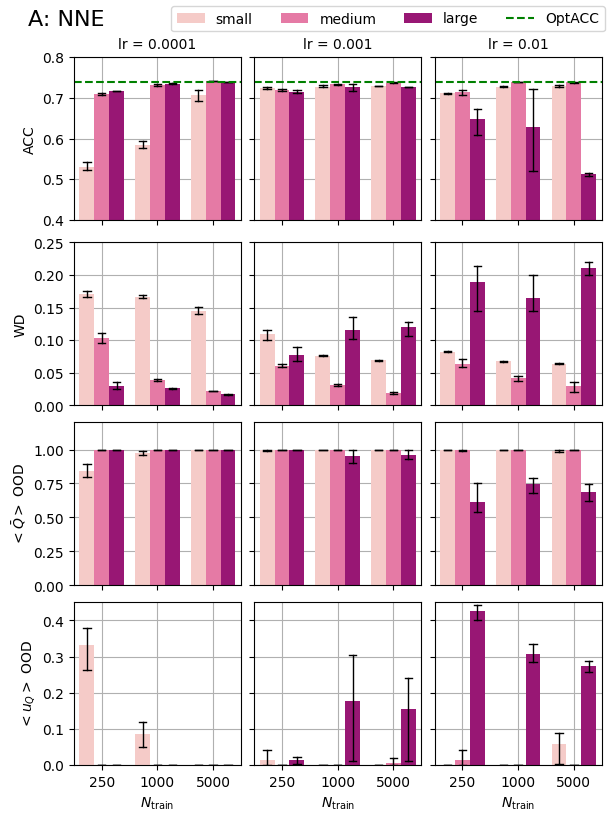

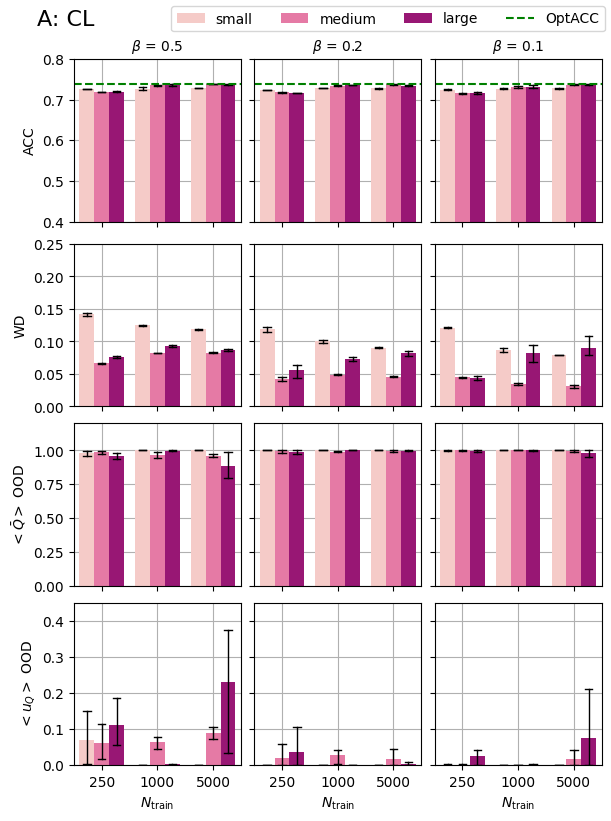

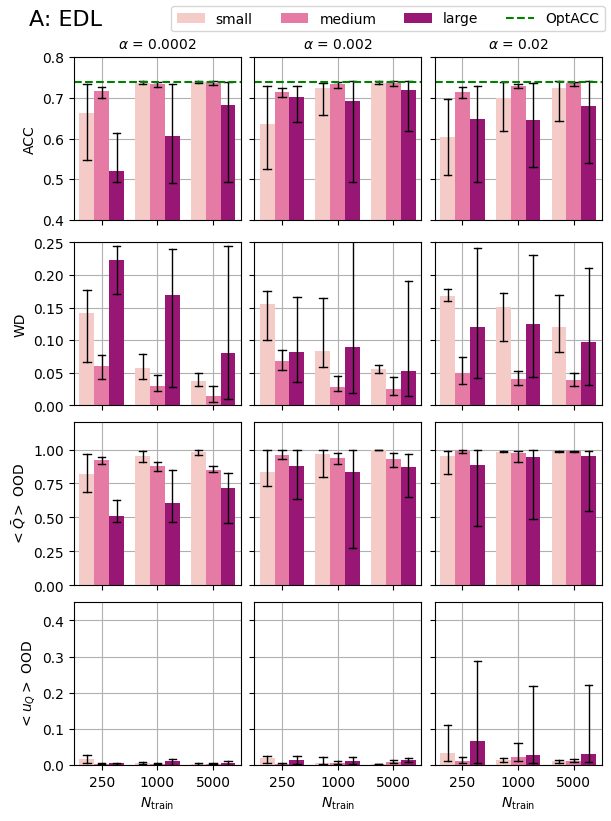

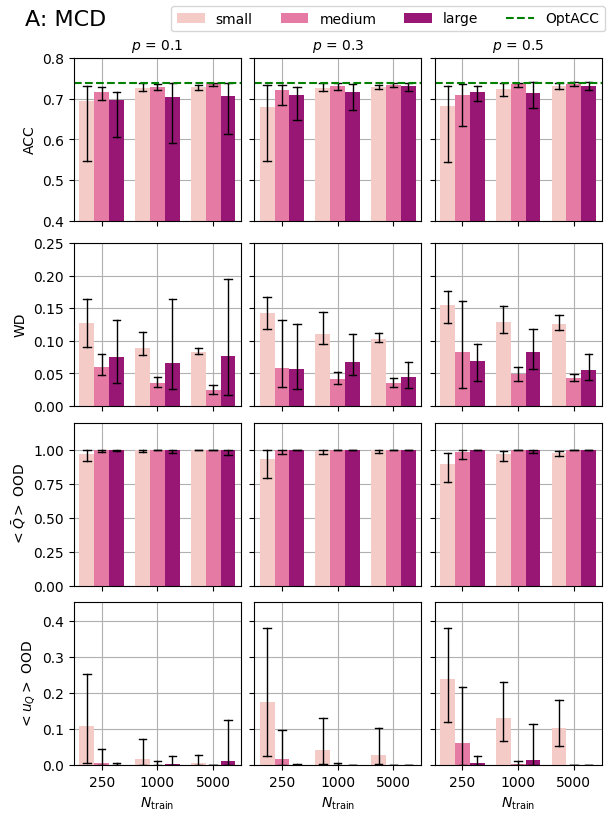

In [14]:
study_plot(dfs_A, model_names, hyperparams, model_hyperparams, model_hyperpams_values, 
           metric_keys, metric_labels, hyperparam_labels, max_acc_A, type="bar", dataset="A")

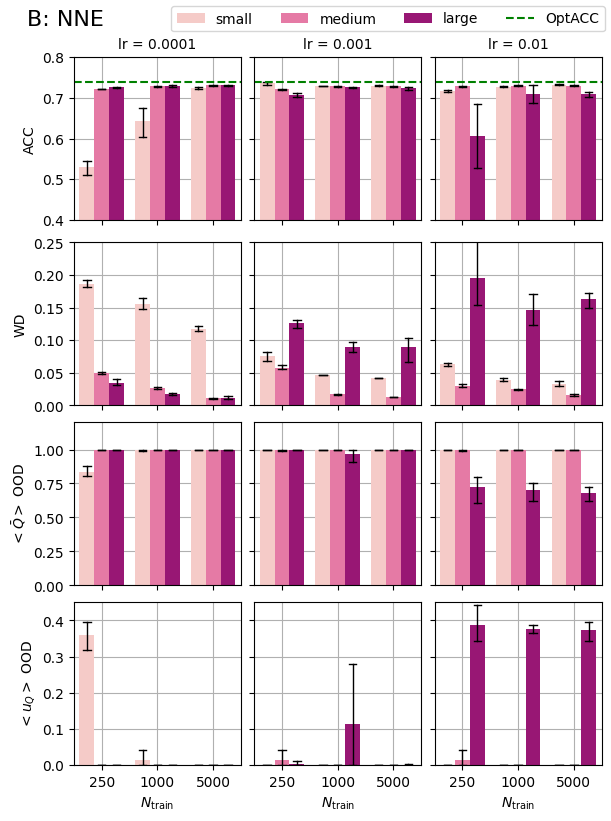

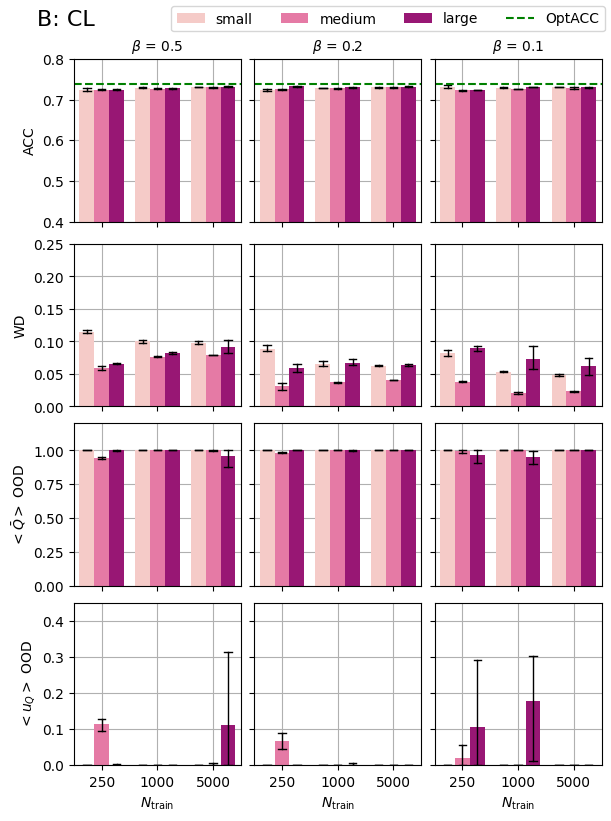

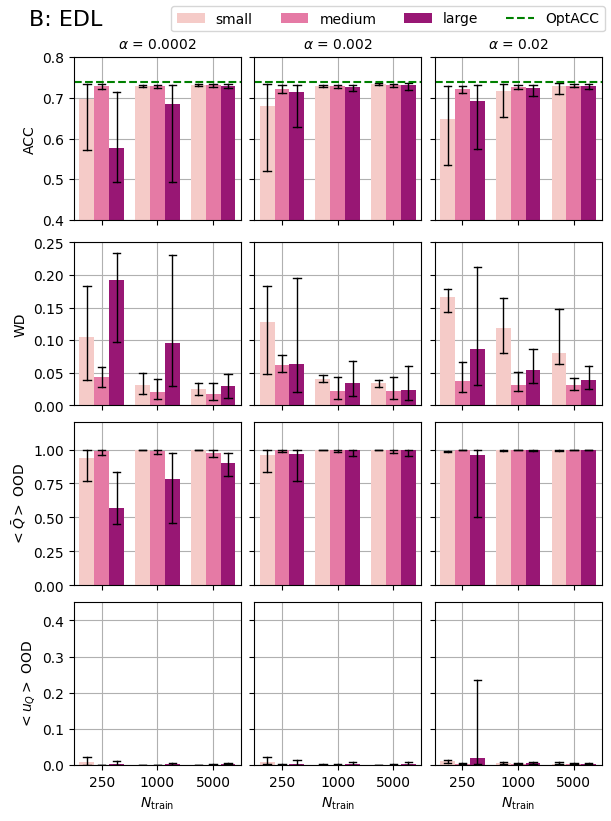

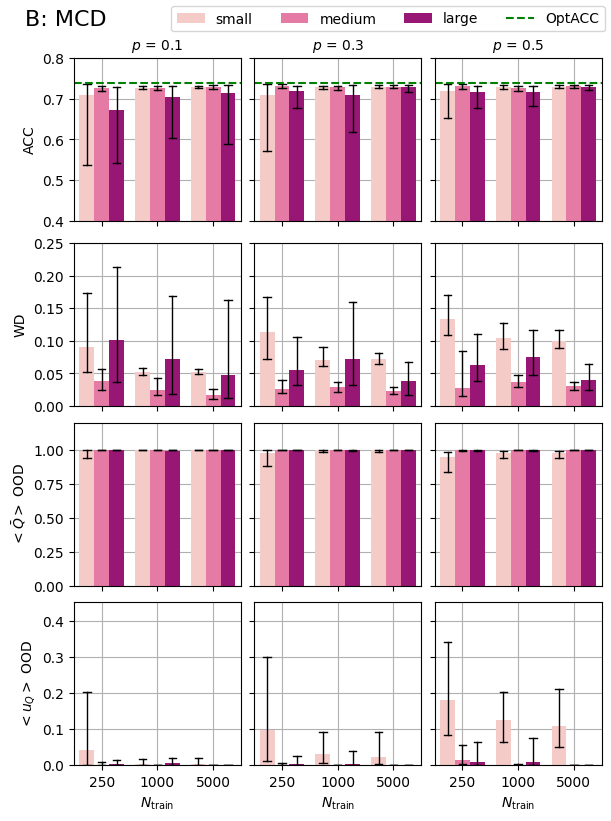

In [11]:
study_plot(dfs_B, model_names, hyperparams, model_hyperparams, model_hyperpams_values, 
           metric_keys, metric_labels, hyperparam_labels, max_acc_B, type="bar", dataset="B")

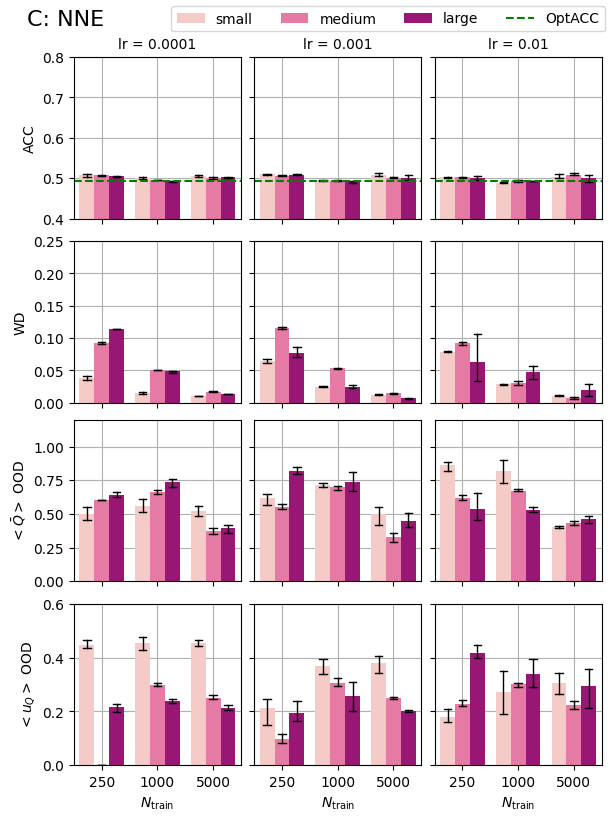

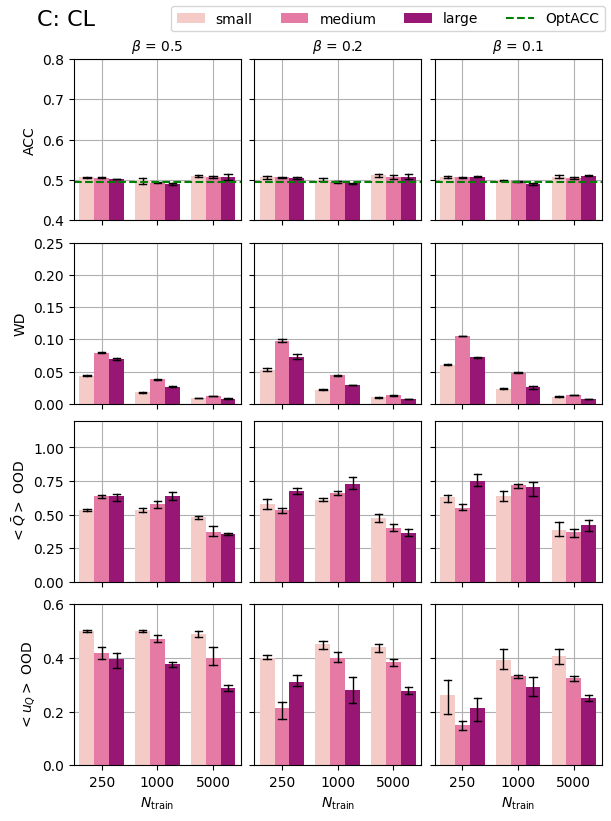

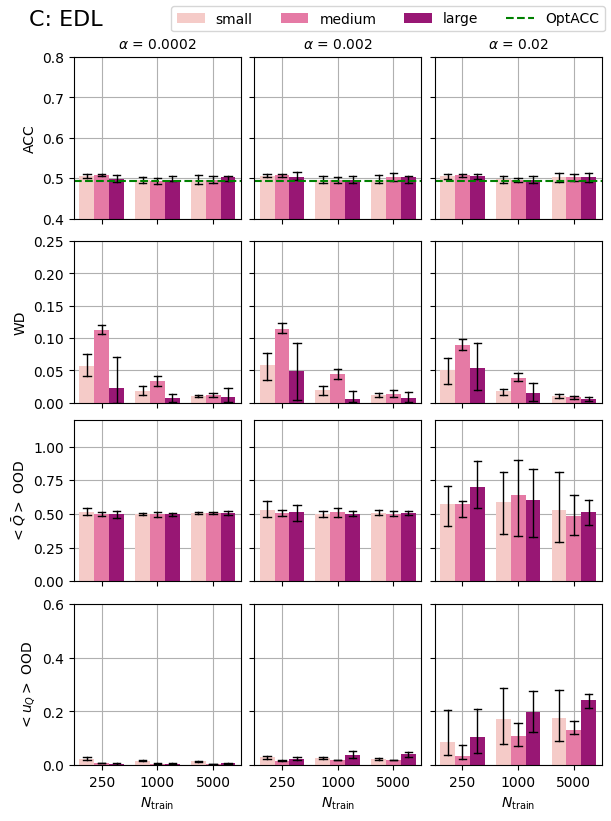

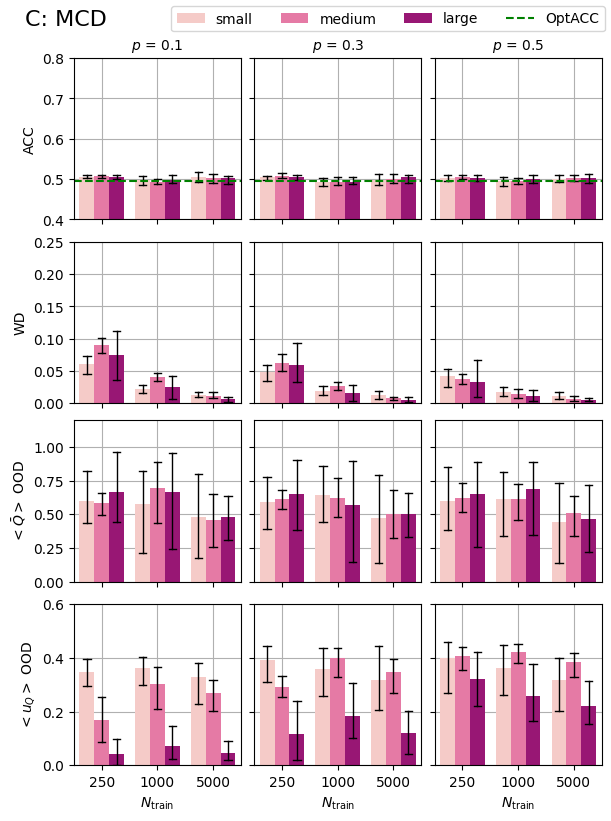

In [25]:
study_plot(dfs_C, model_names, hyperparams, model_hyperparams, model_hyperpams_values, 
           metric_keys, metric_labels, hyperparam_labels, max_acc_C, type="bar", dataset="C")

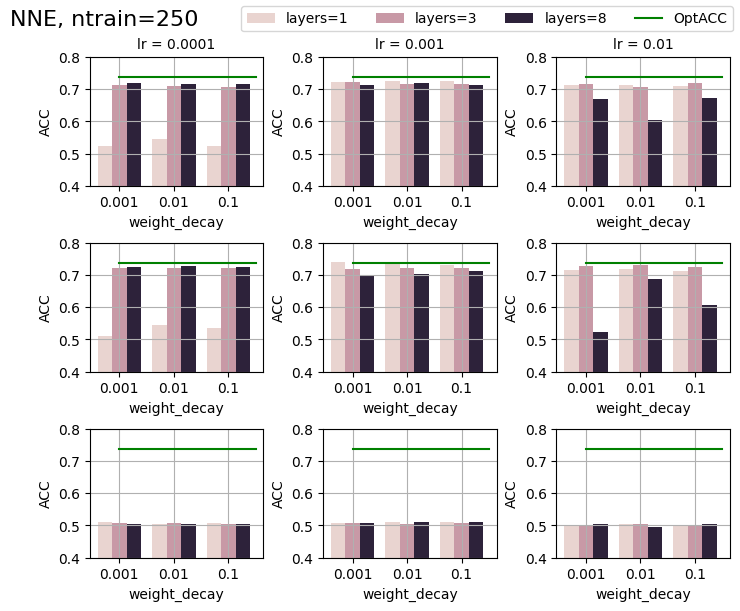

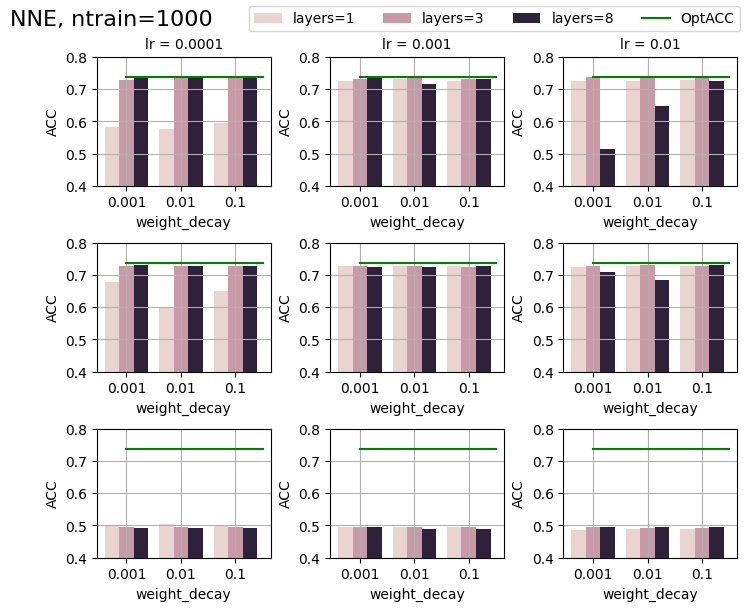

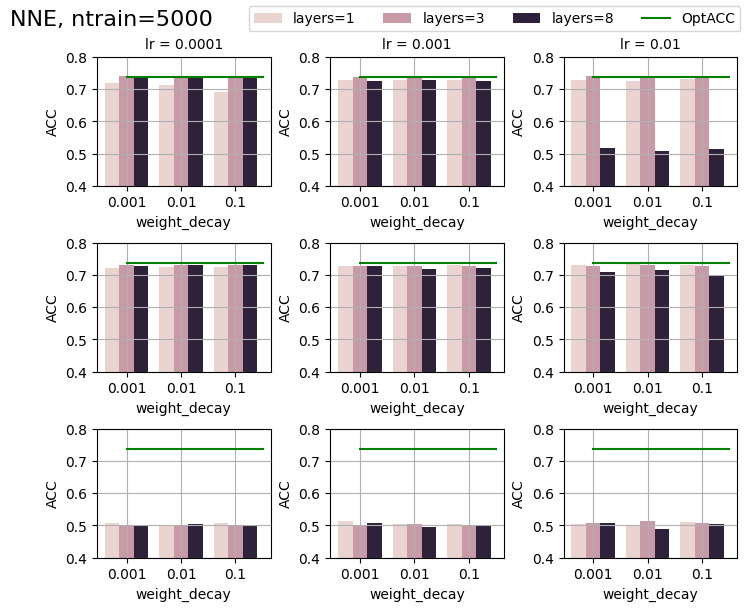

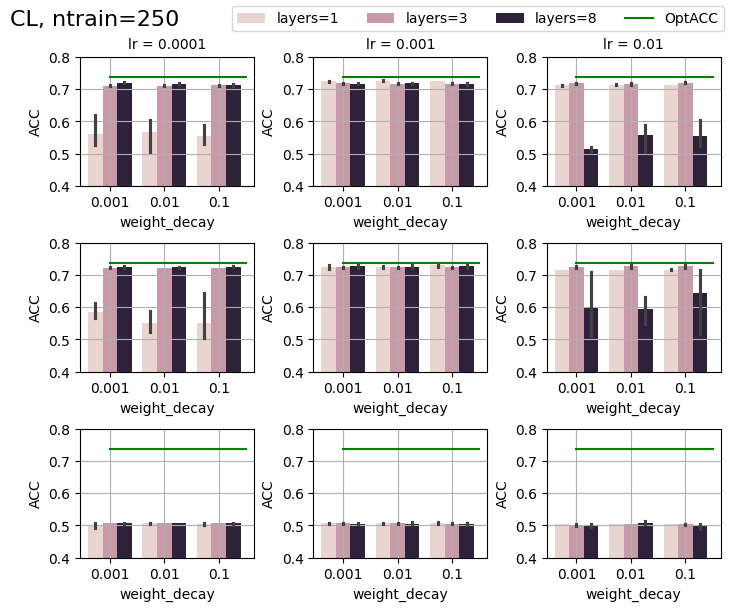

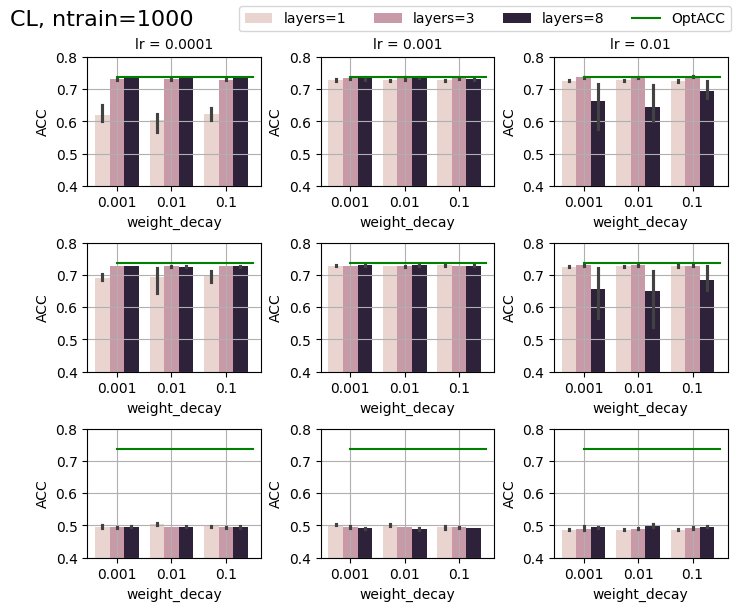

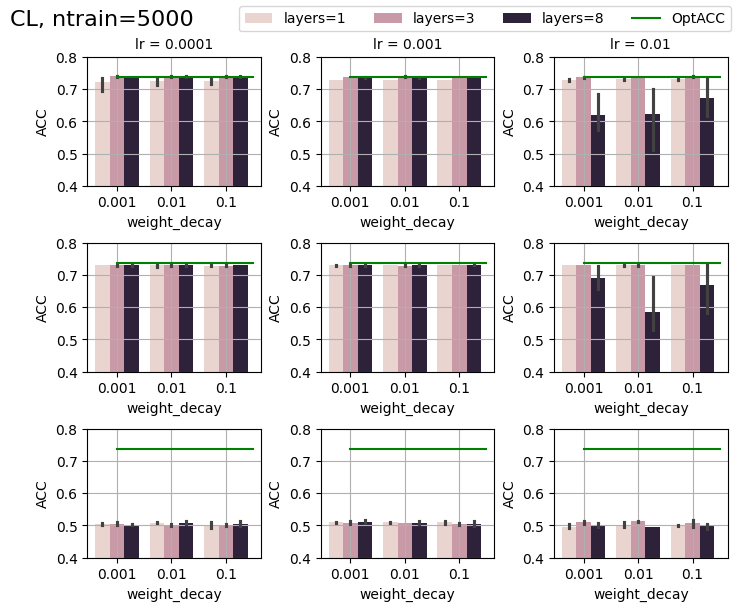

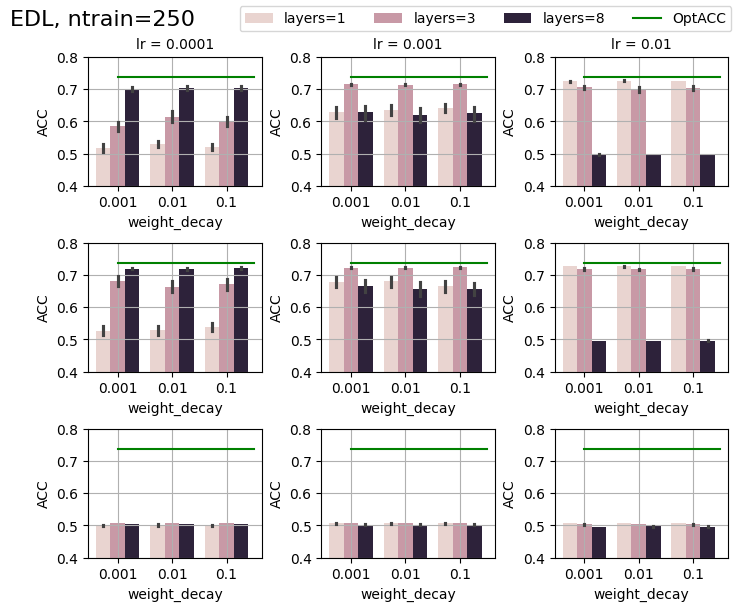

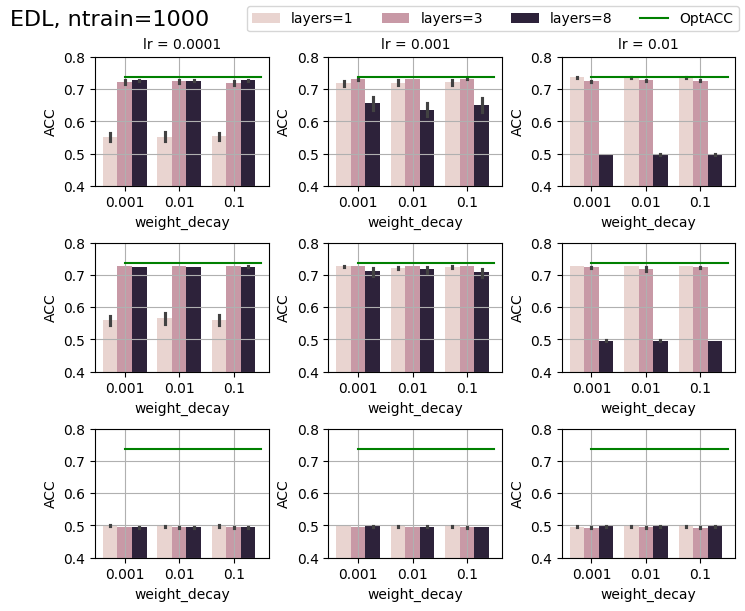

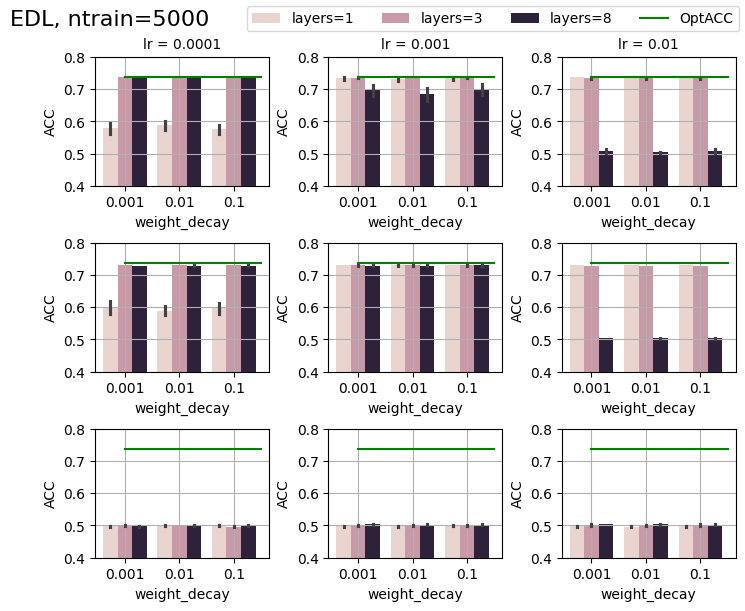

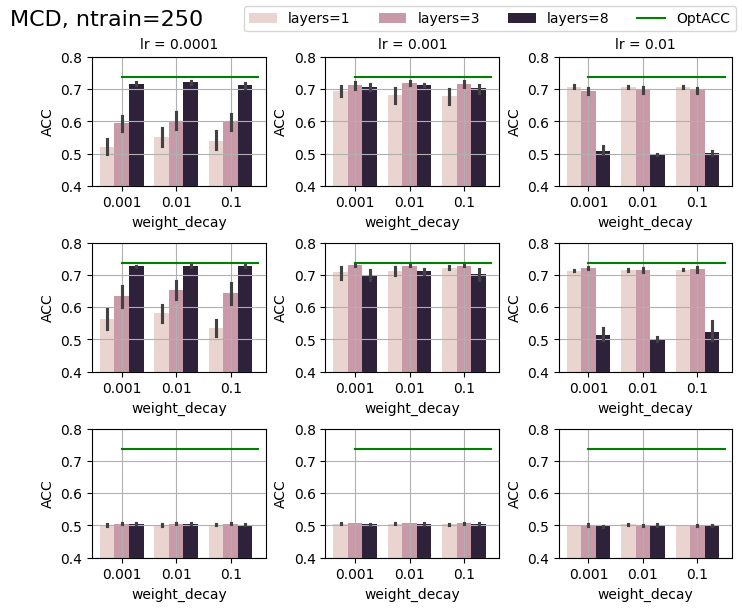

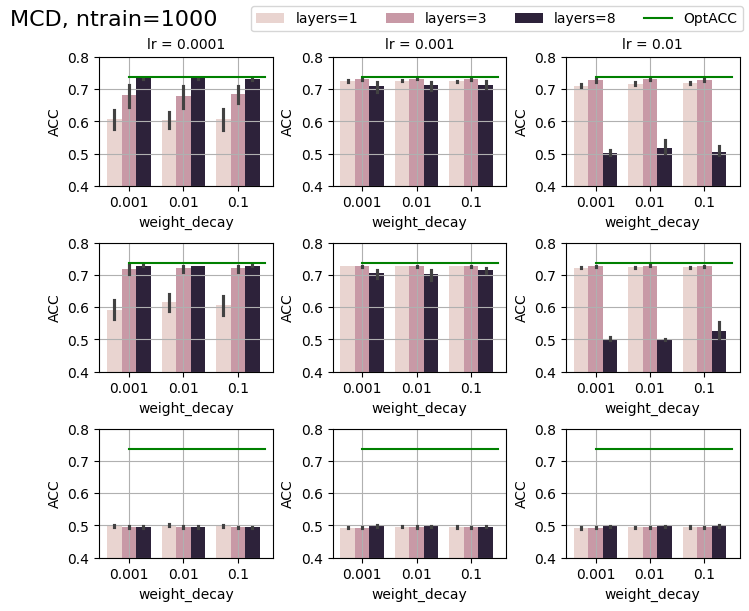

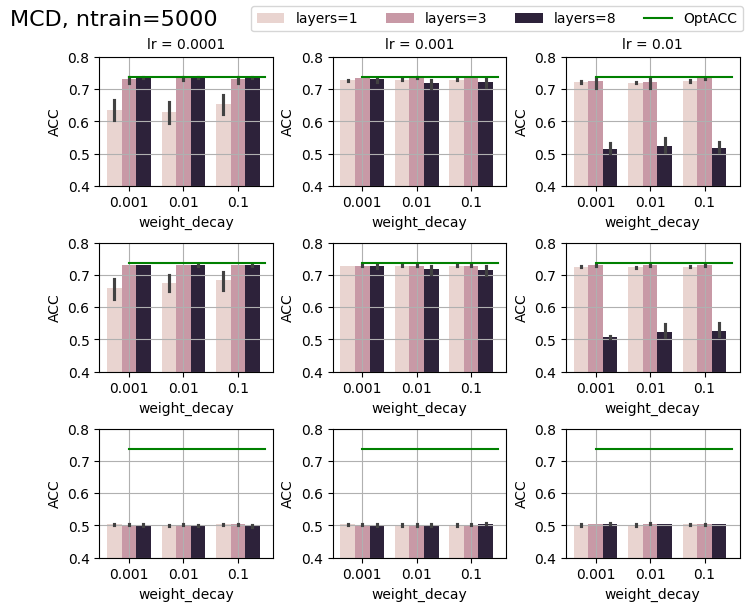

In [17]:
plot_hyperparams(dfs_A, dfs_B, dfs_C, model_names, n_data, hyperparams, "ACC", ymin=0.4, ymax=0.1, max_acc=max_acc_A)

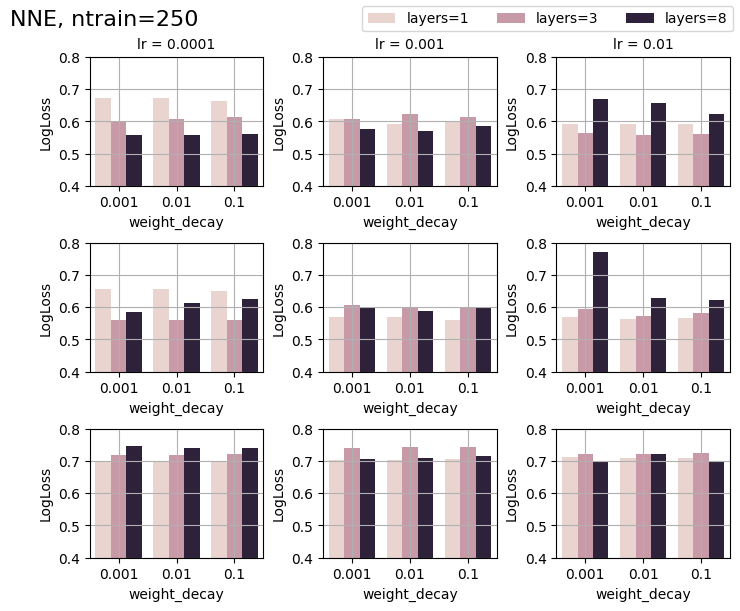

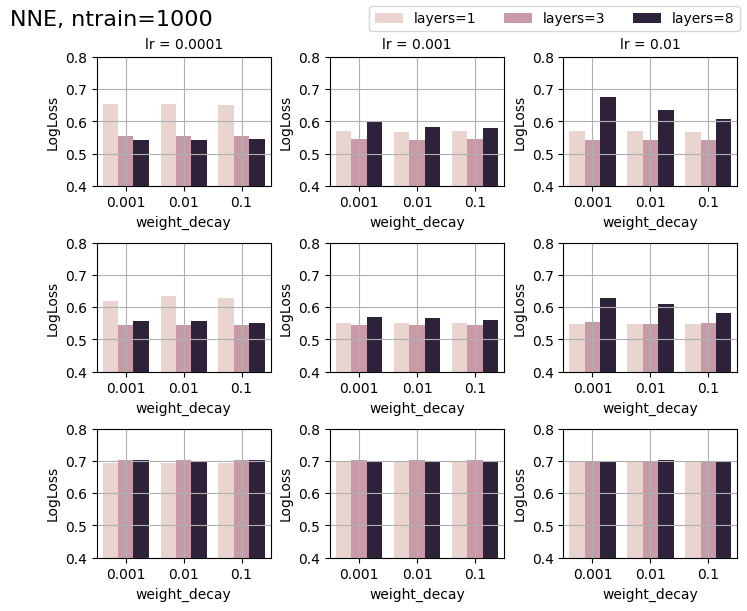

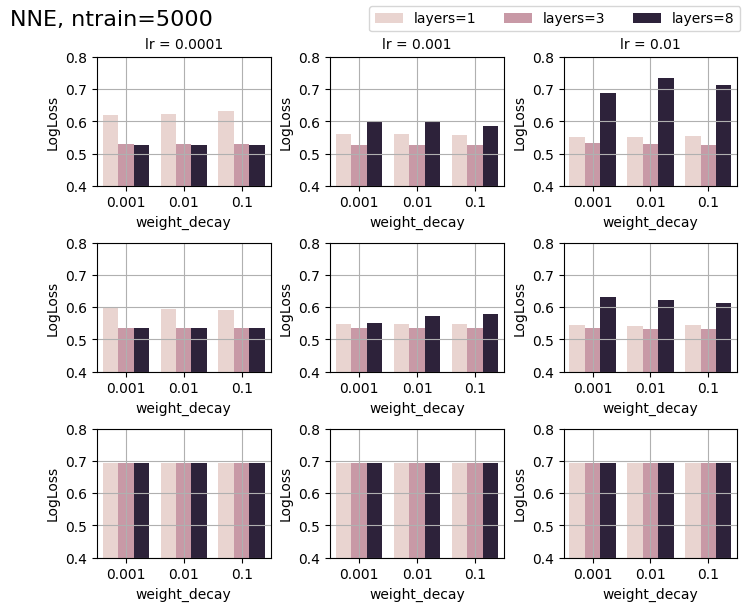

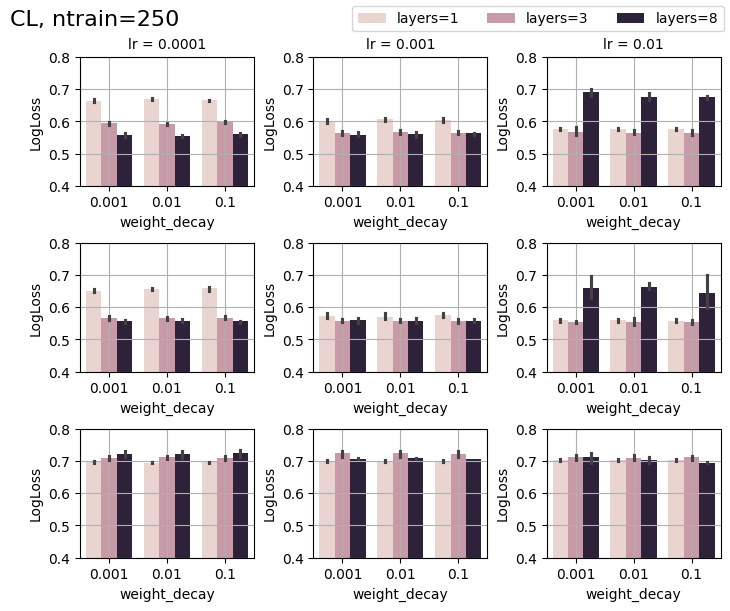

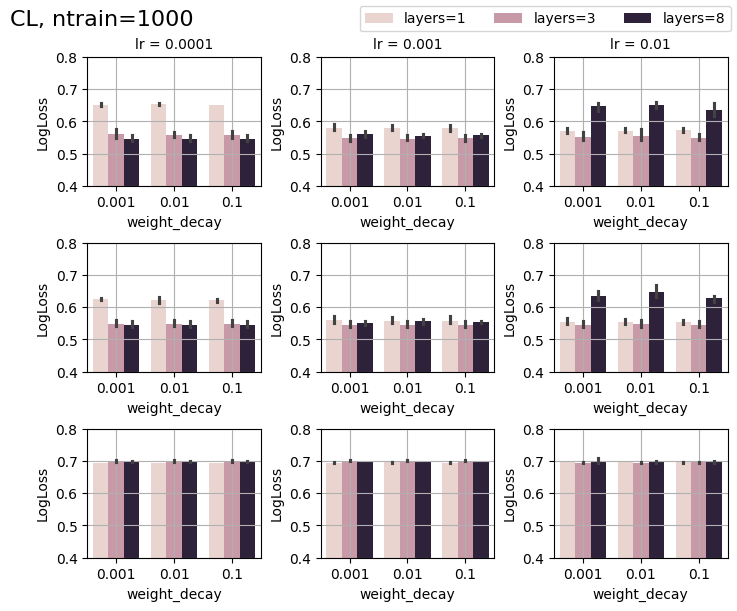

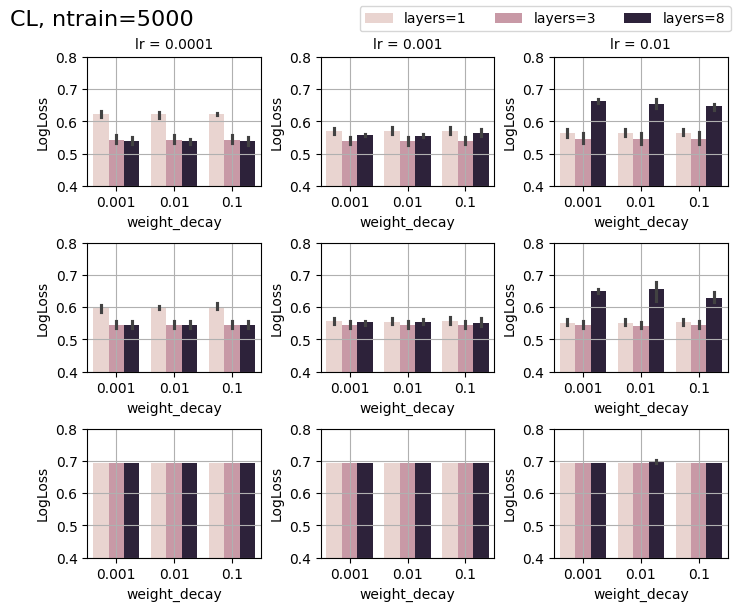

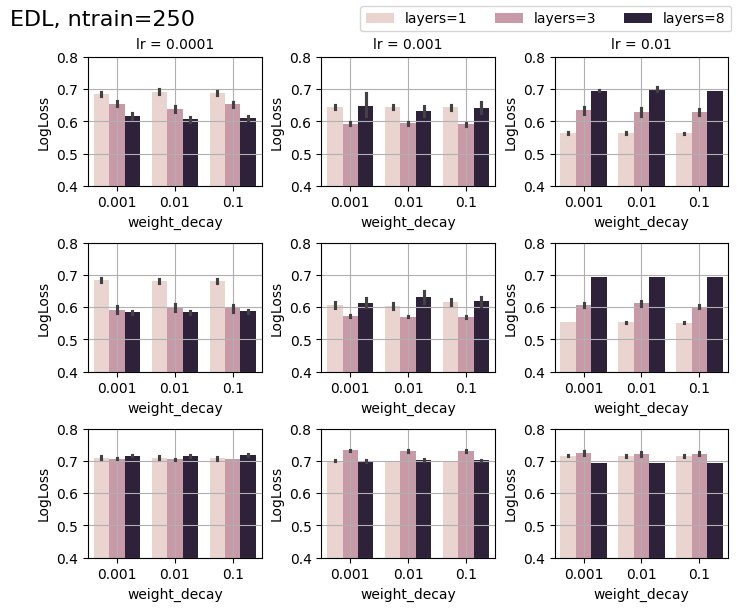

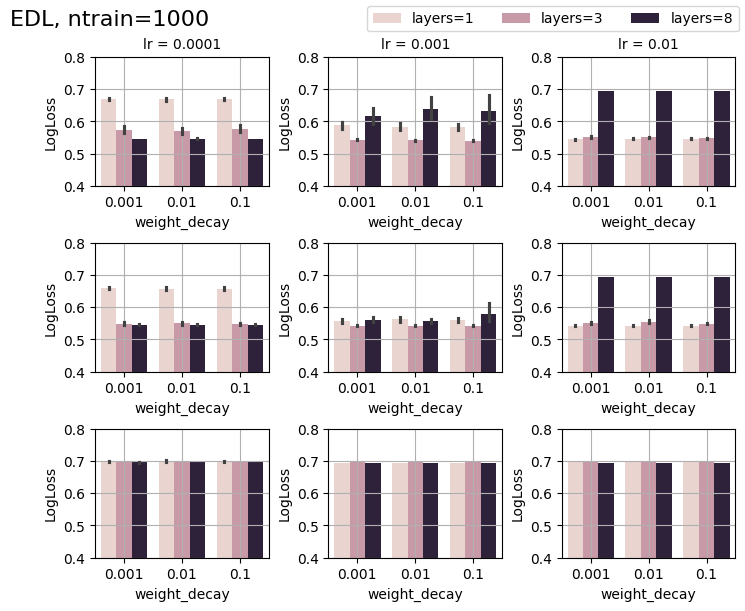

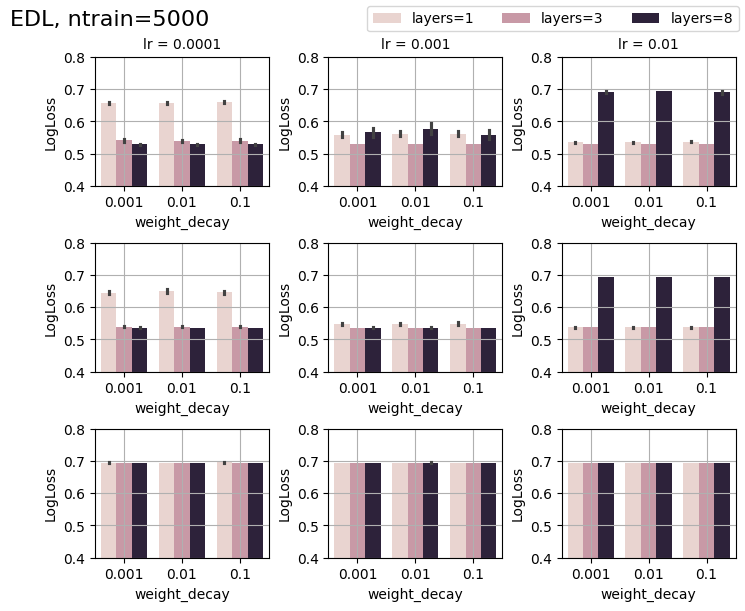

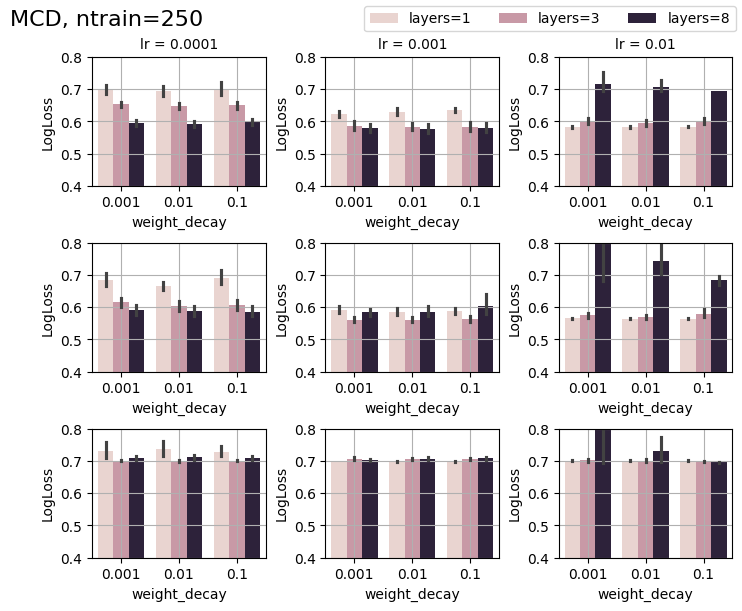

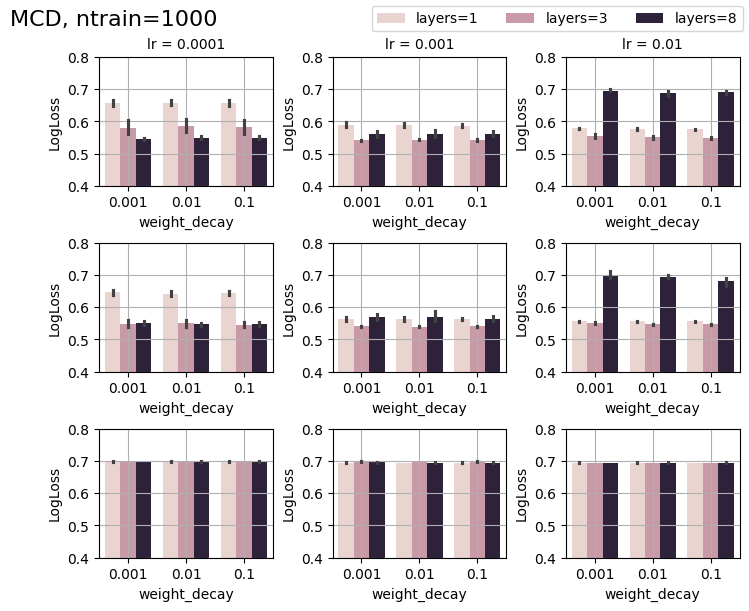

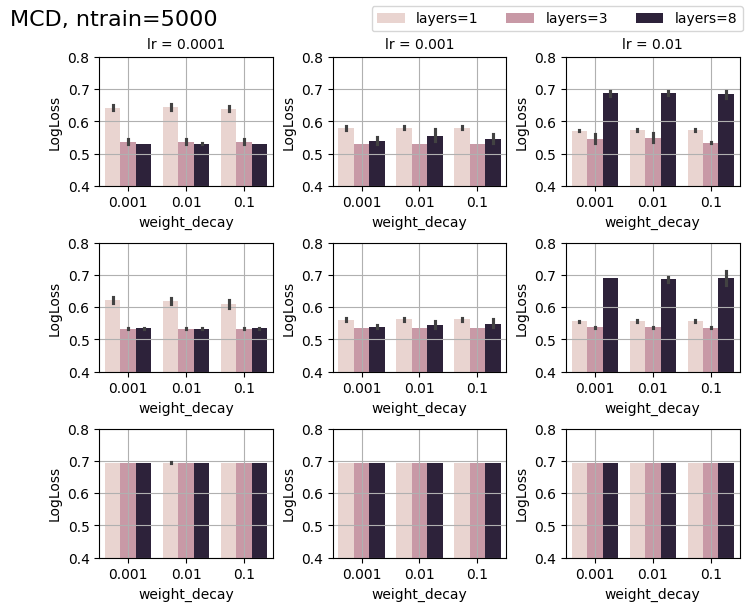

In [18]:
plot_hyperparams(dfs_A, dfs_B, dfs_C, model_names, n_data, hyperparams, "LogLoss", ymin=0.4, ymax=0.8)

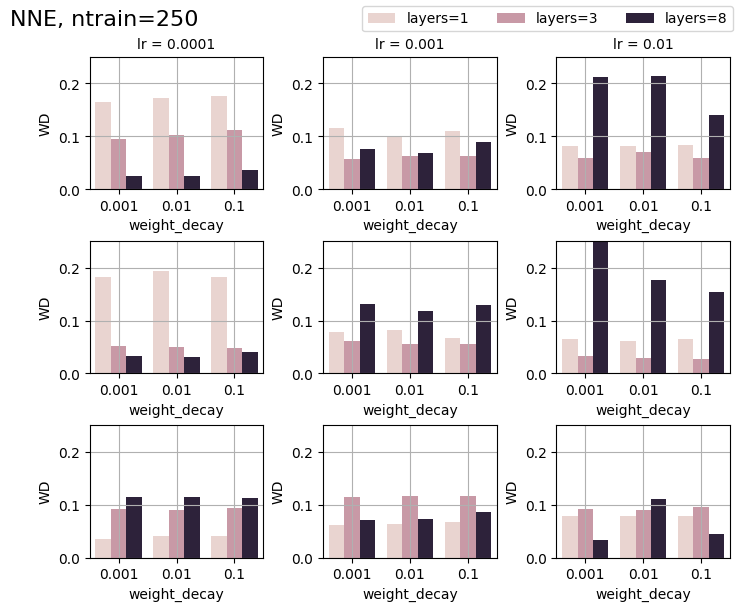

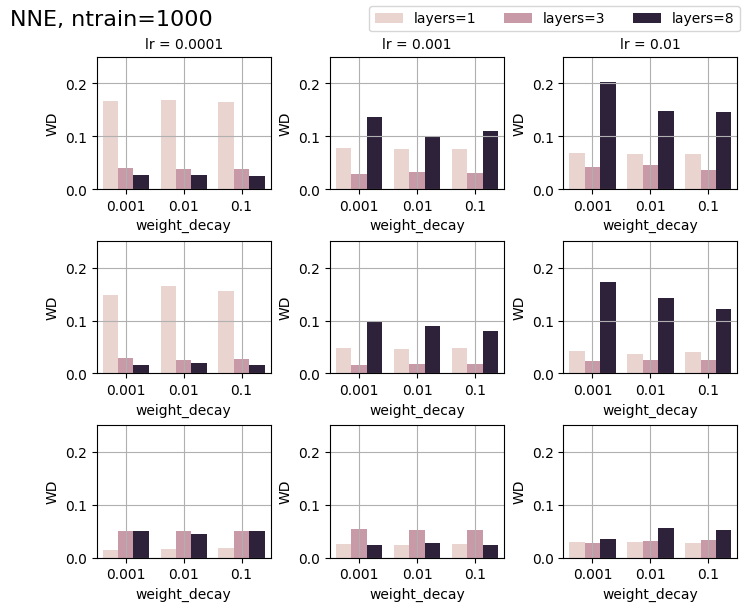

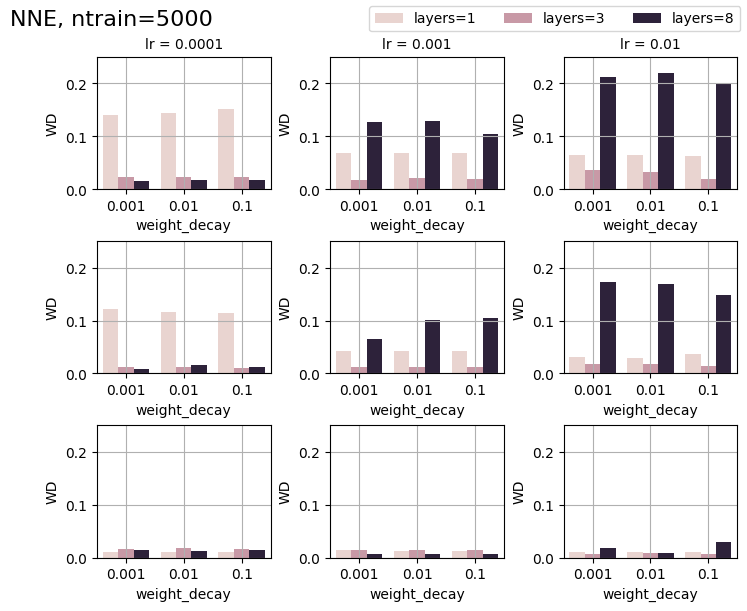

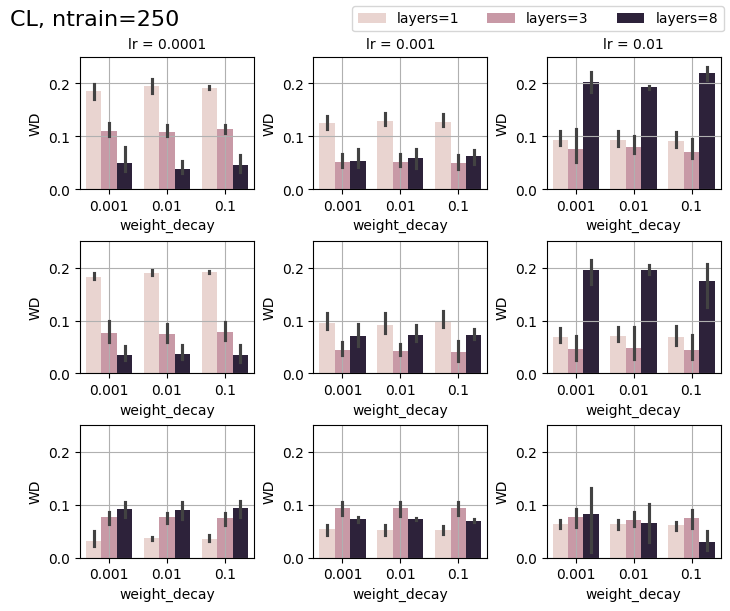

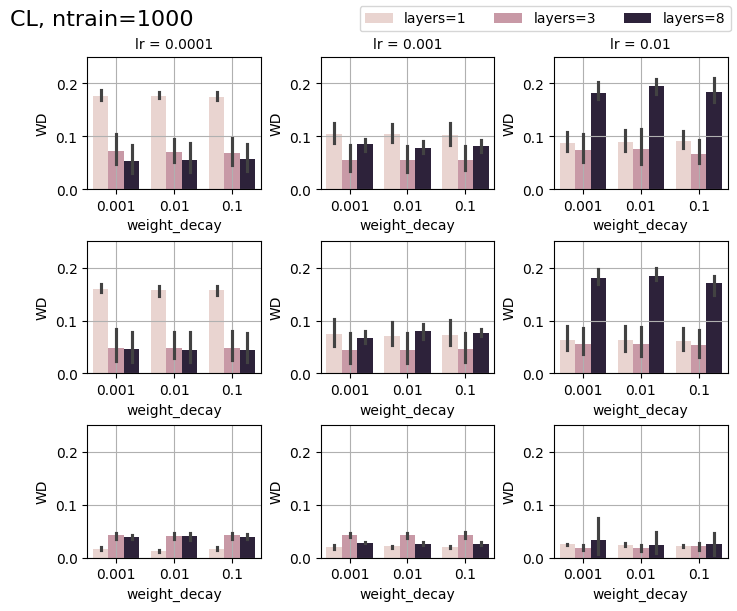

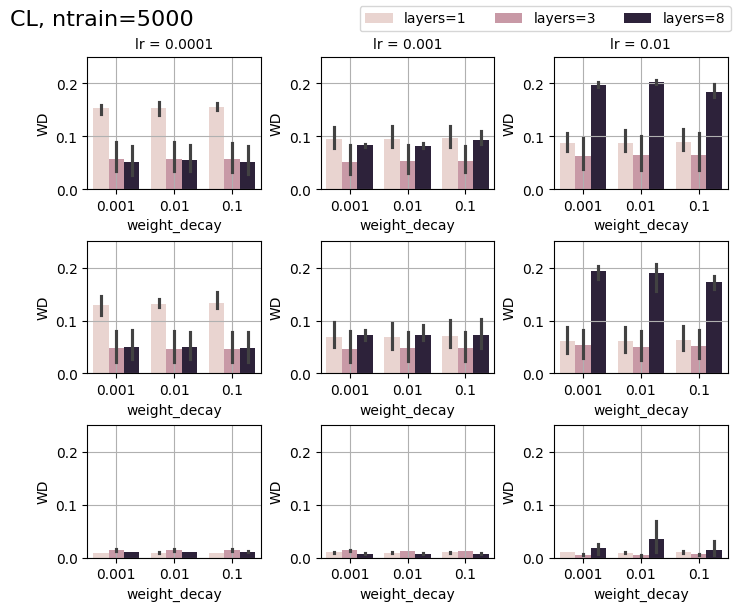

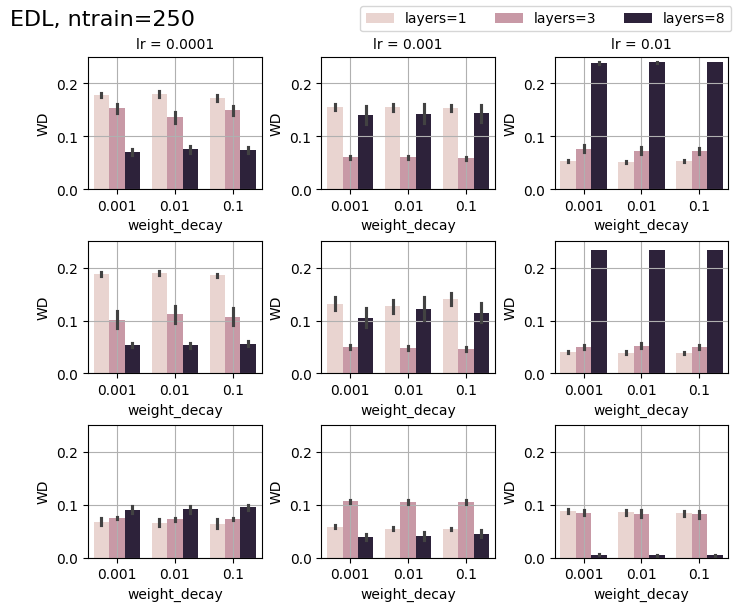

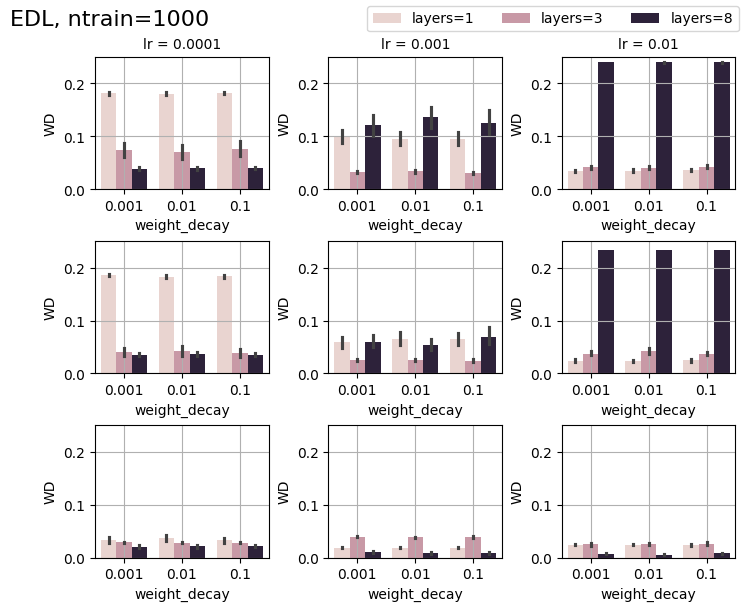

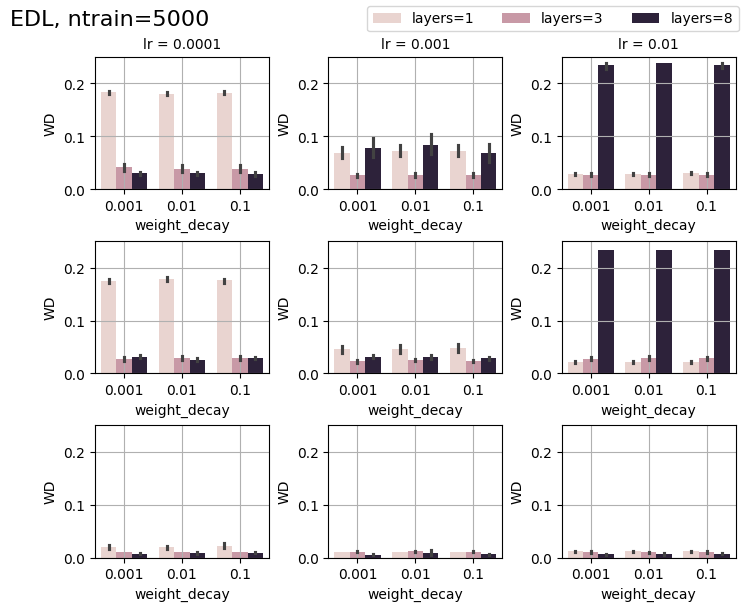

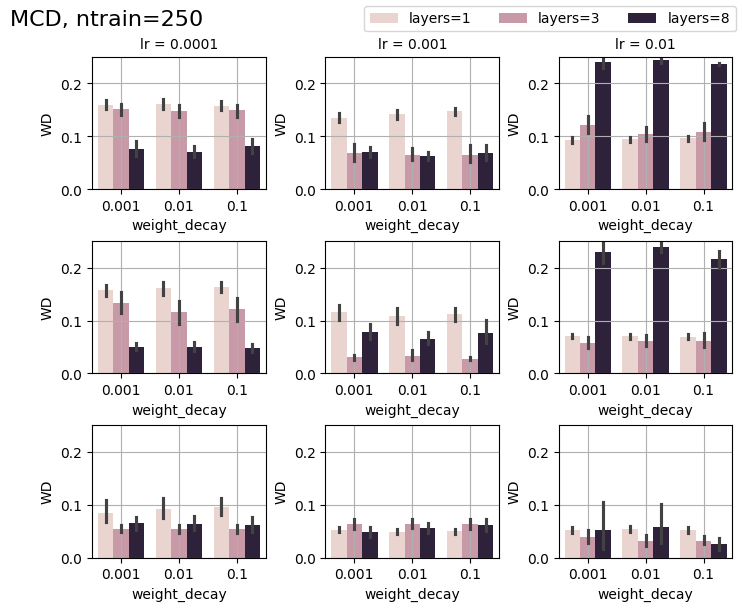

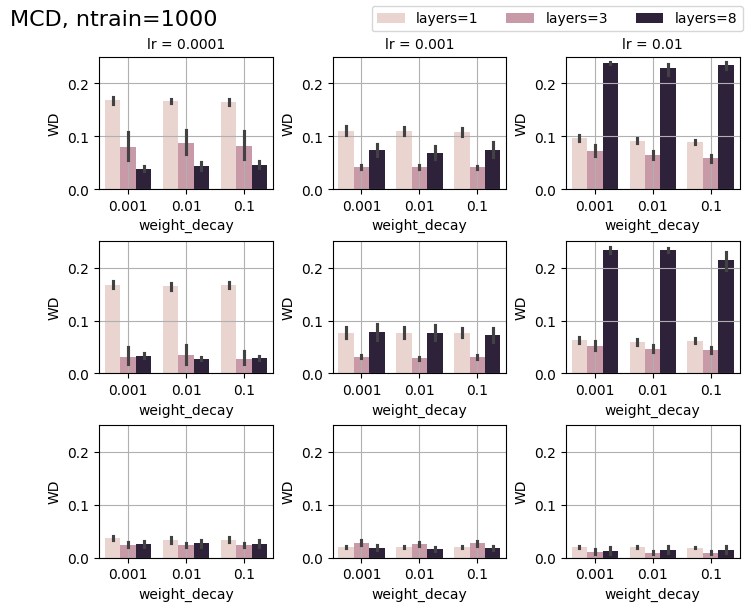

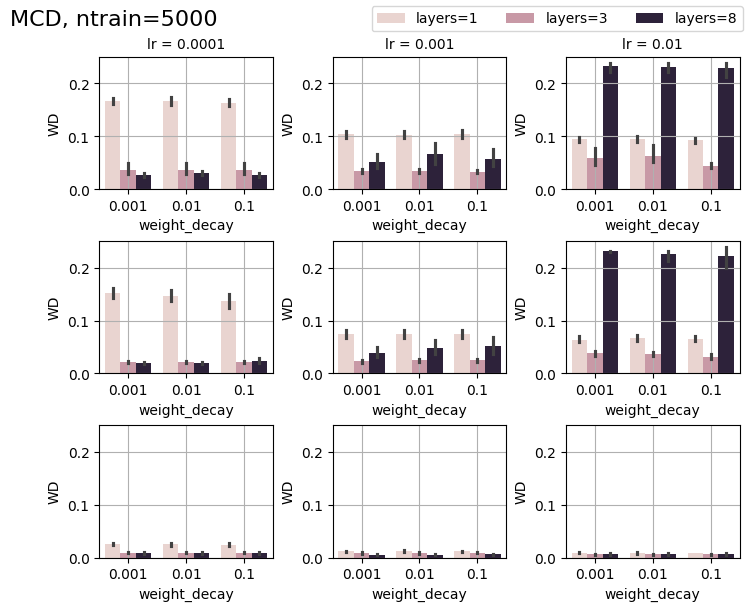

In [19]:
plot_hyperparams(dfs_A, dfs_B, dfs_C, model_names, n_data, hyperparams, "WD", ymin=0, ymax=0.25)

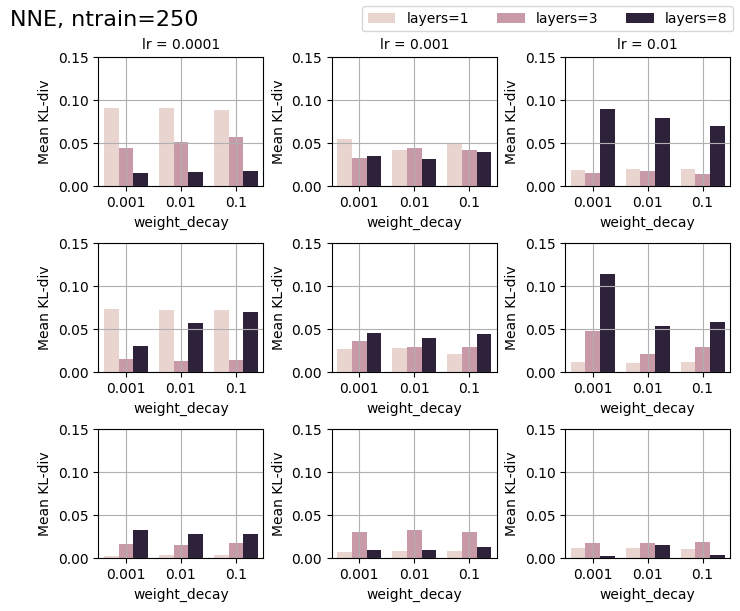

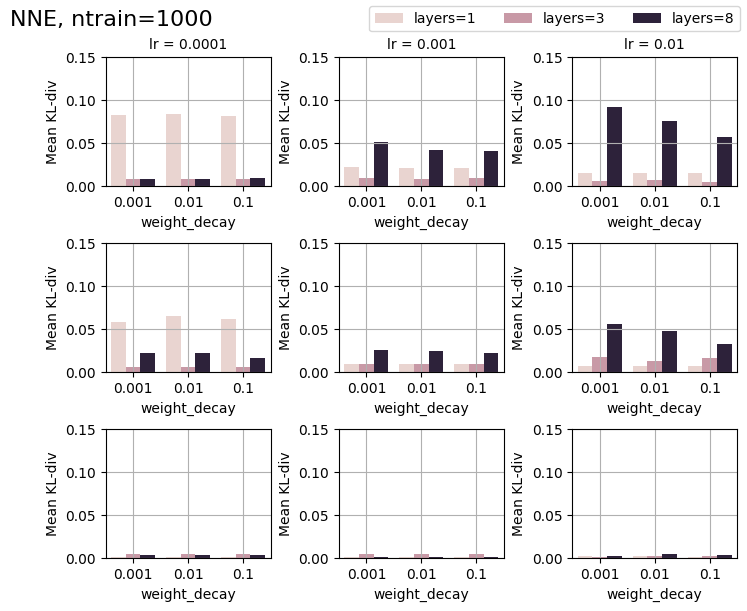

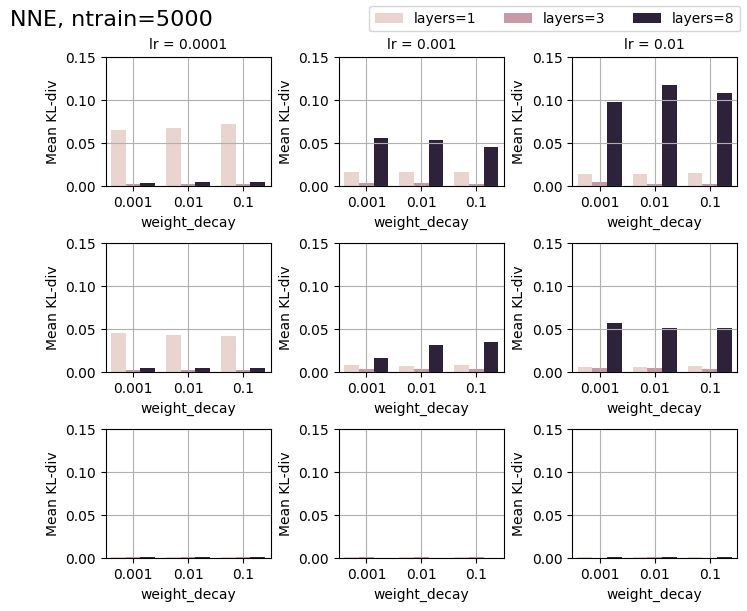

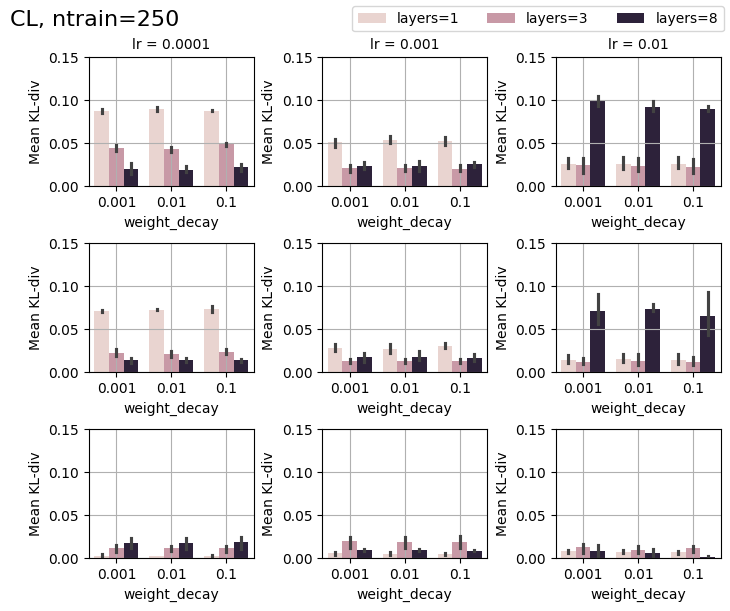

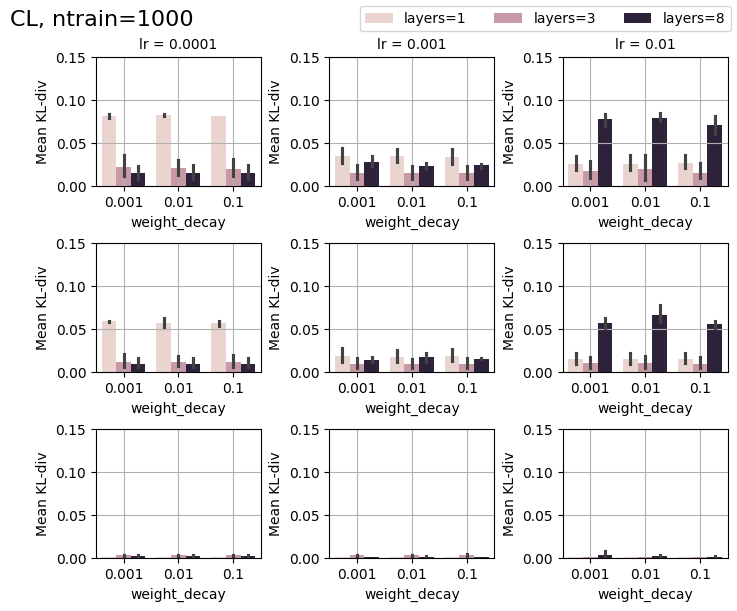

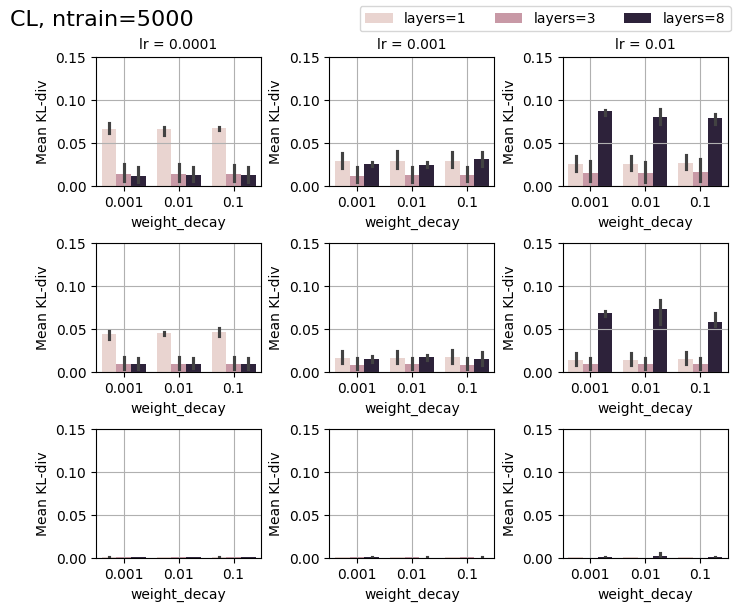

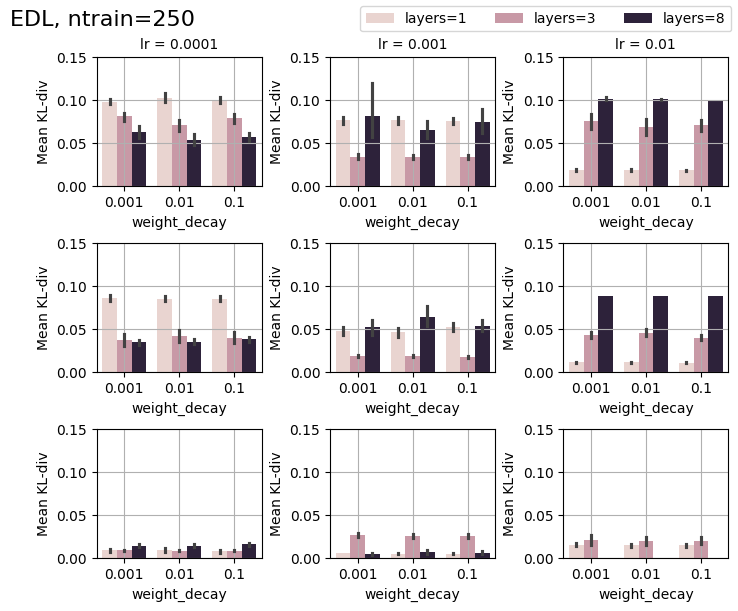

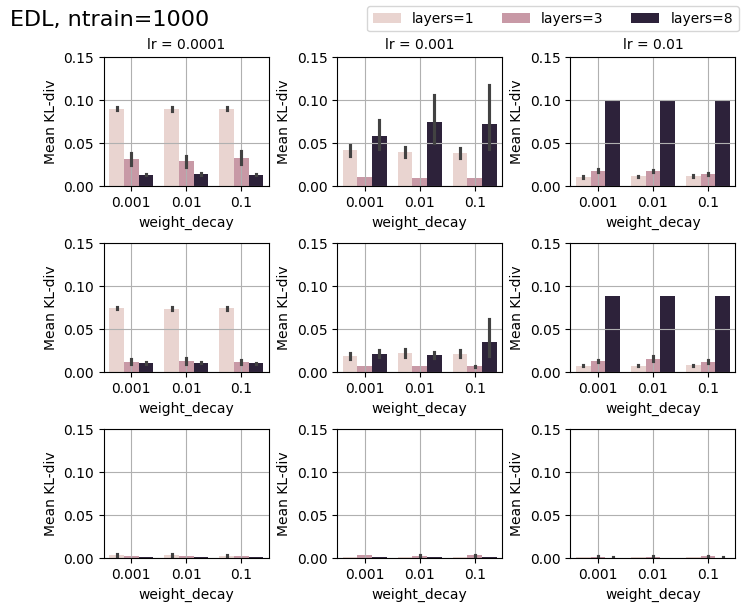

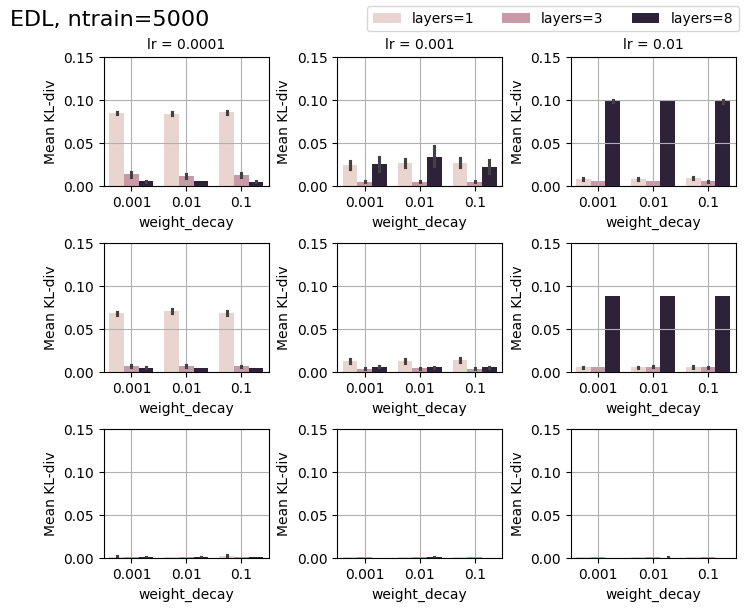

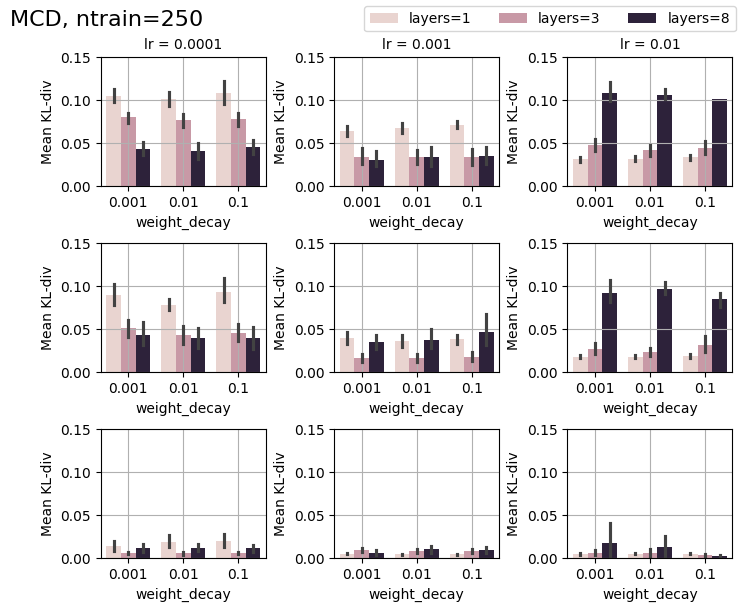

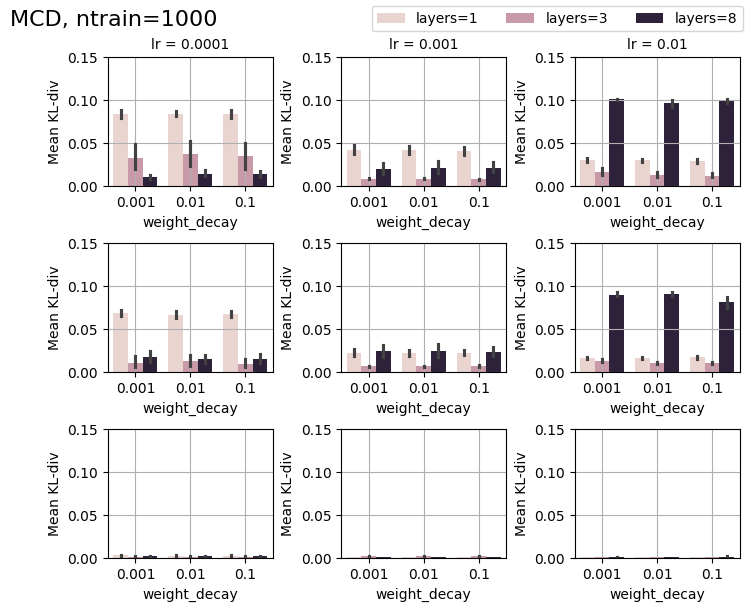

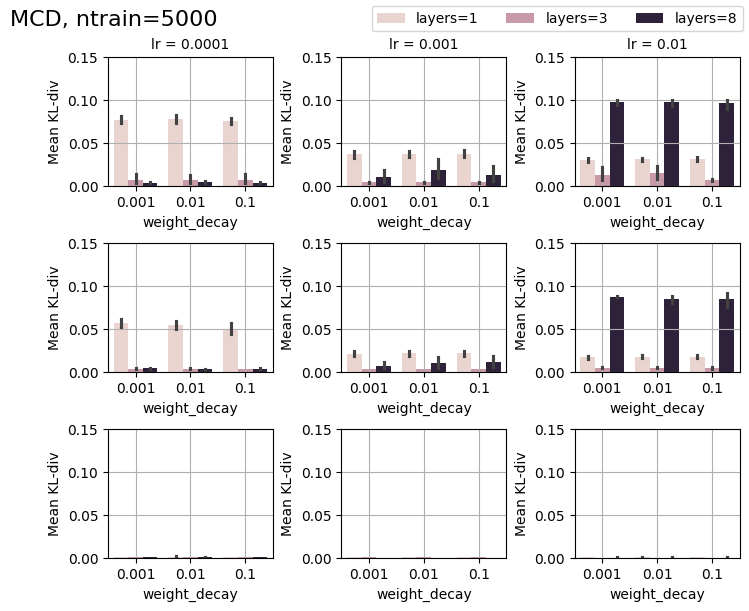

In [20]:
plot_hyperparams(dfs_A, dfs_B, dfs_C, model_names, n_data, hyperparams, "Mean KL-div", ymin=0, ymax=0.15)


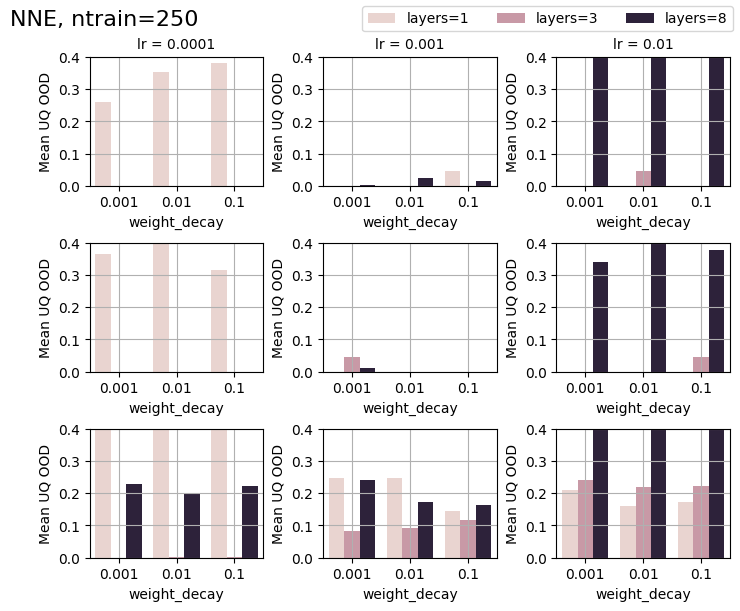

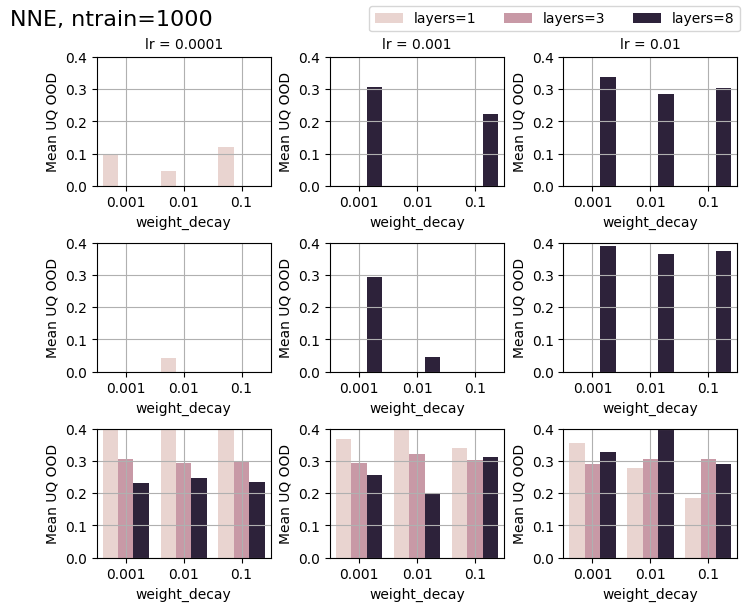

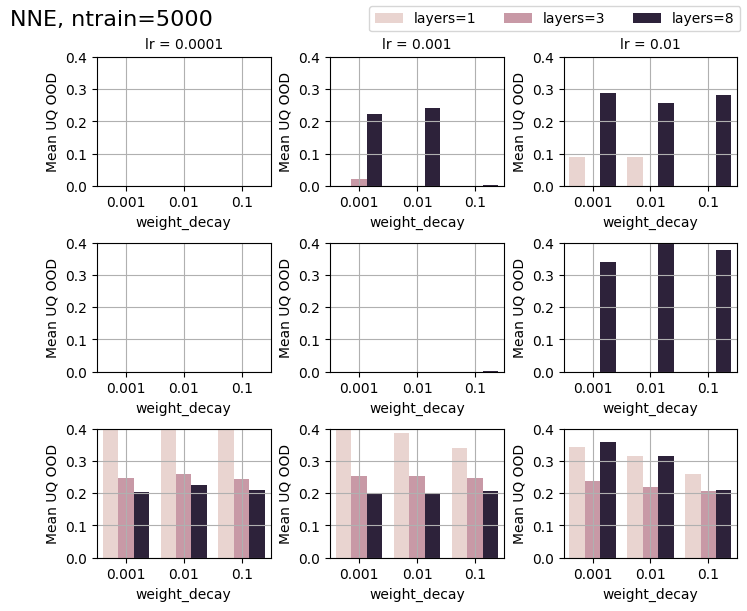

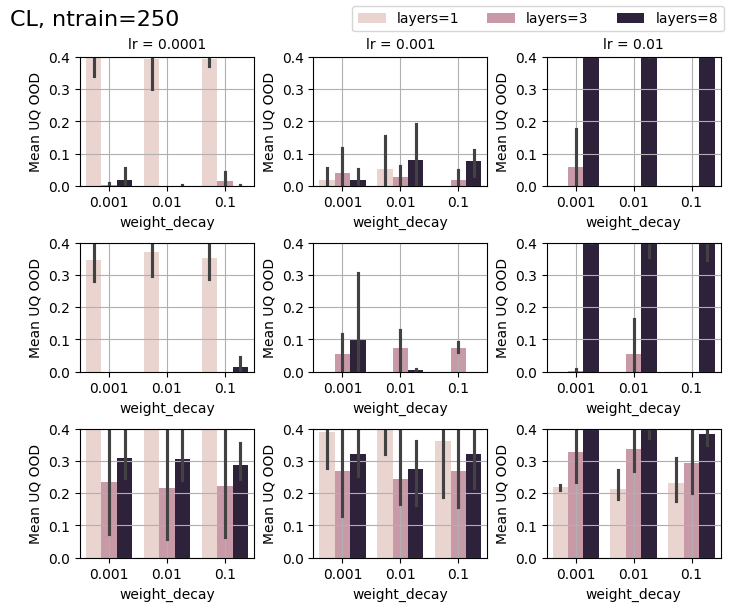

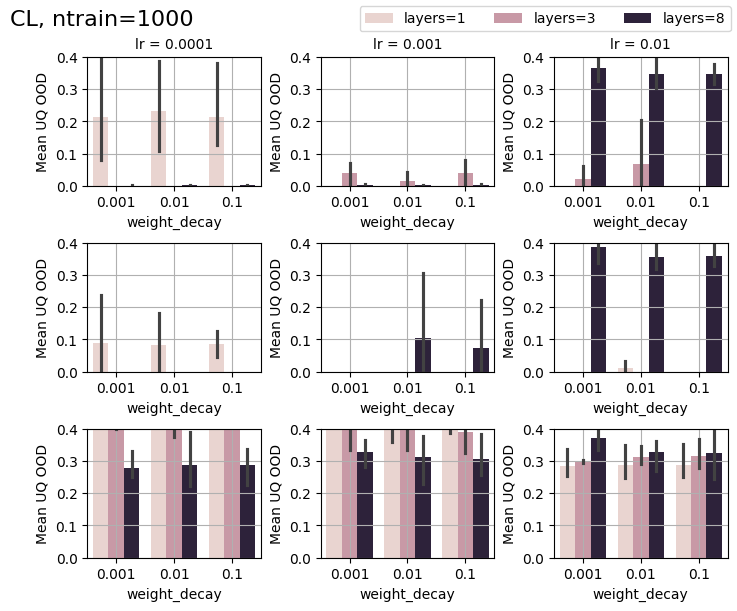

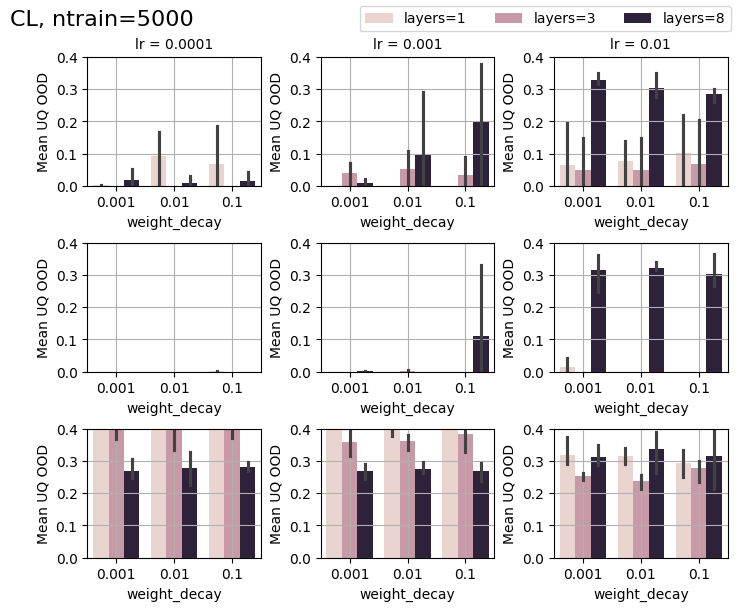

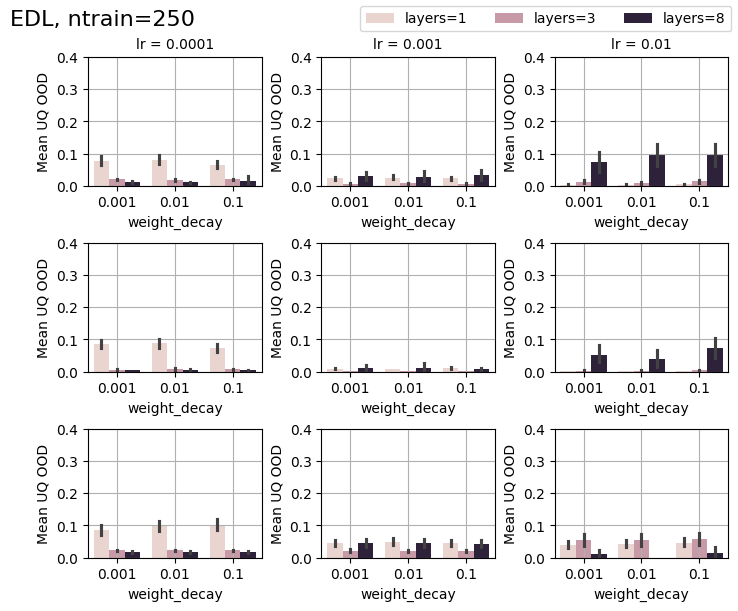

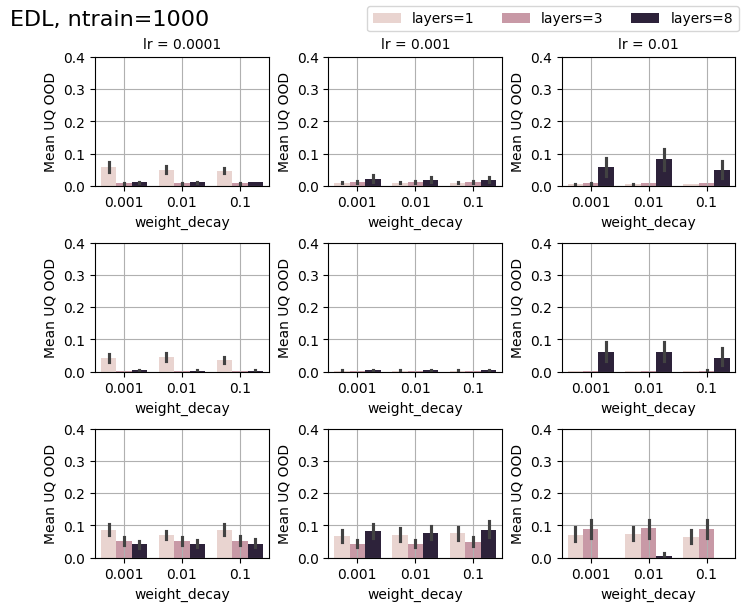

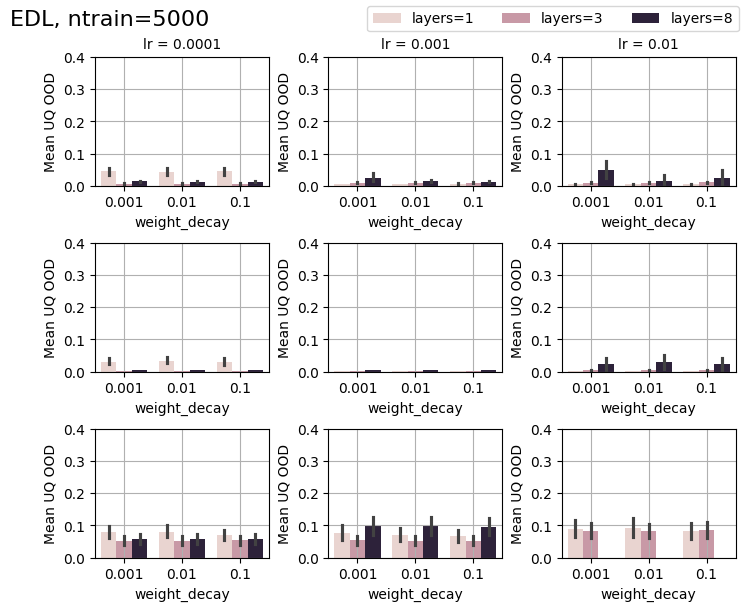

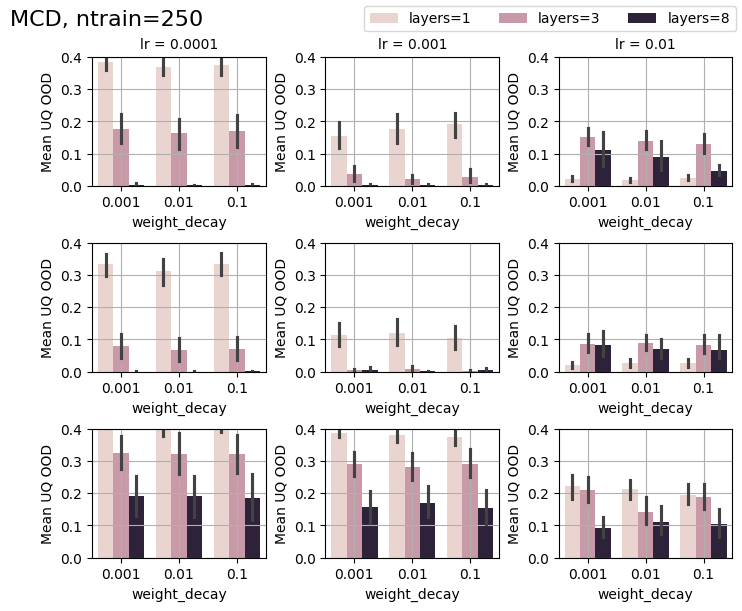

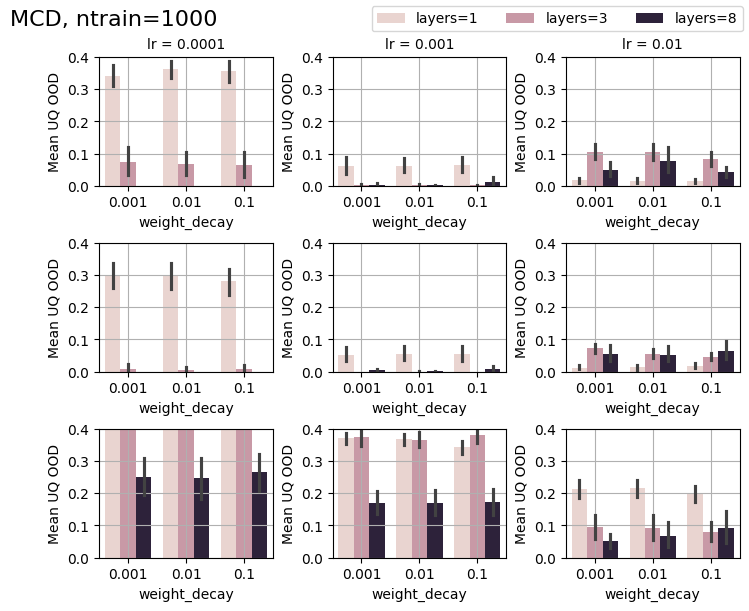

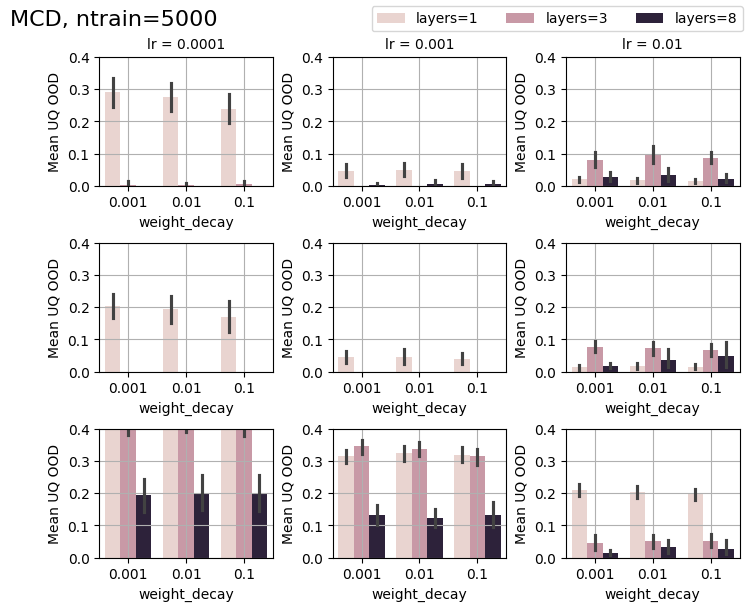

In [21]:
plot_hyperparams(dfs_A, dfs_B, dfs_C, model_names, n_data, hyperparams, "Mean UQ OOD", ymin=0, ymax=0.4)


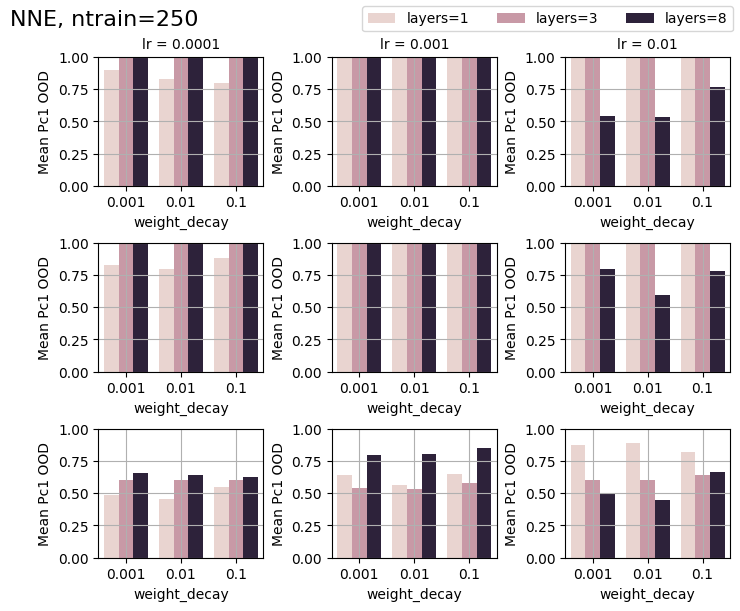

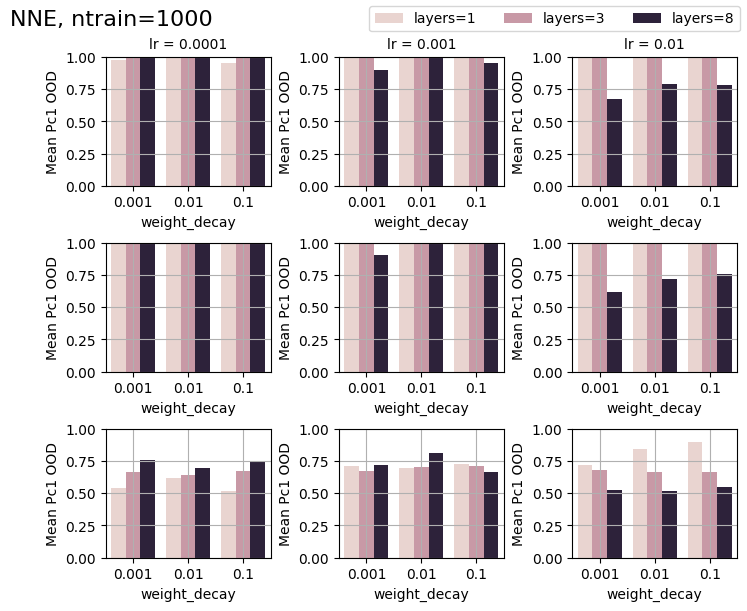

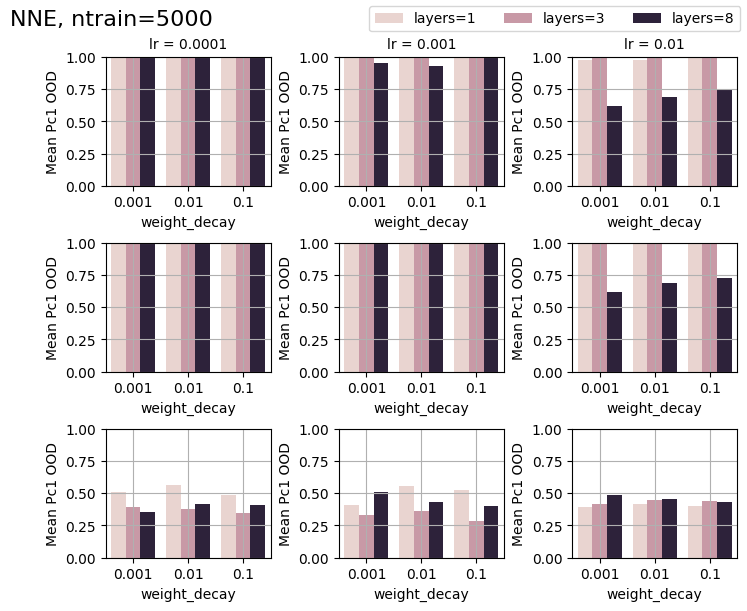

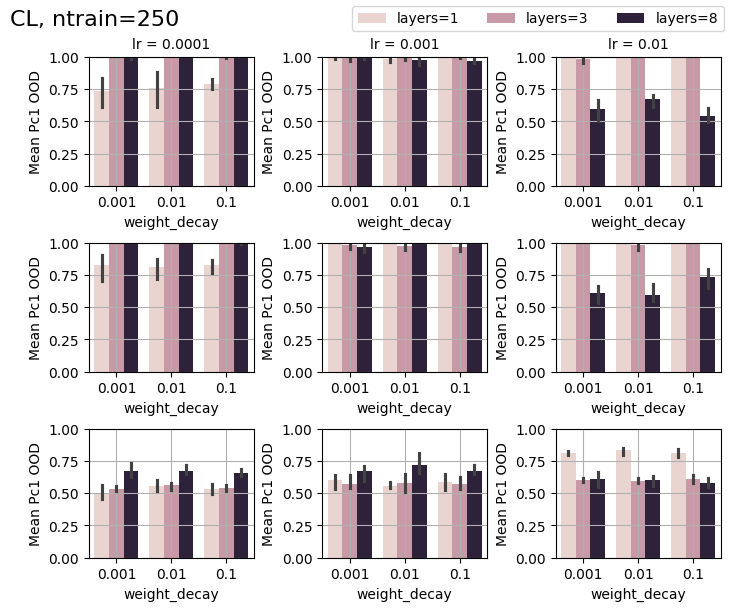

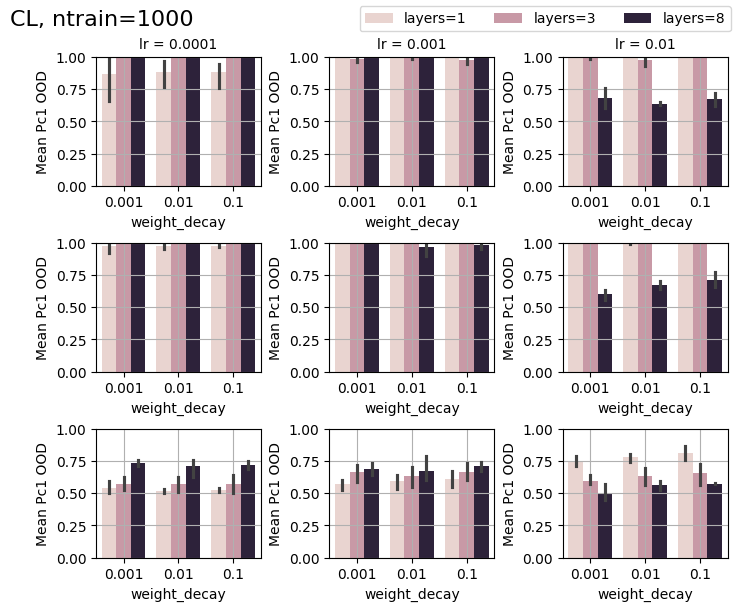

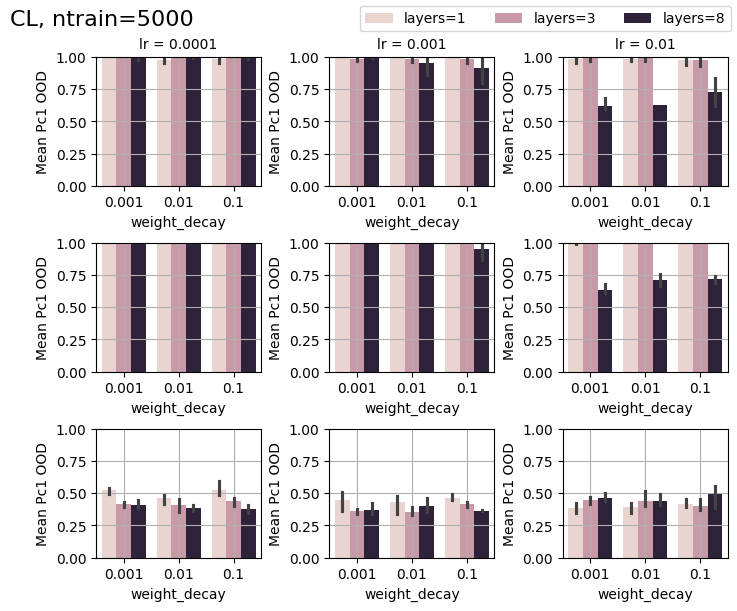

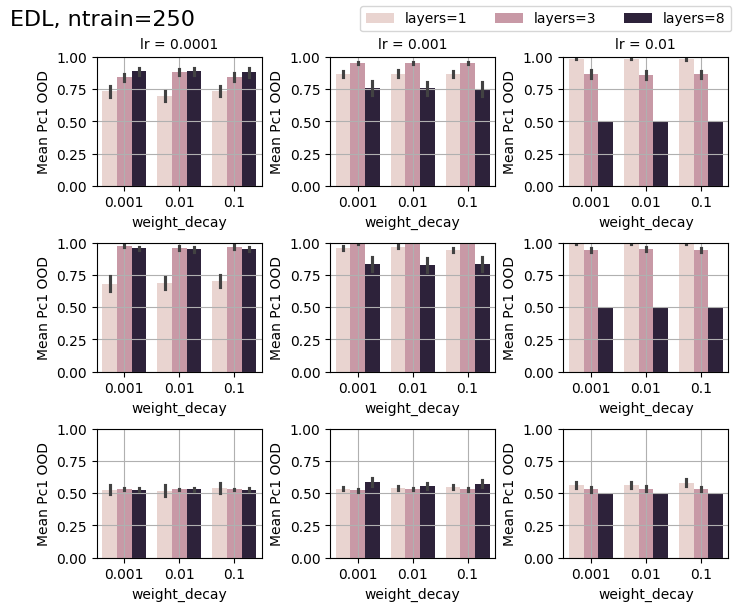

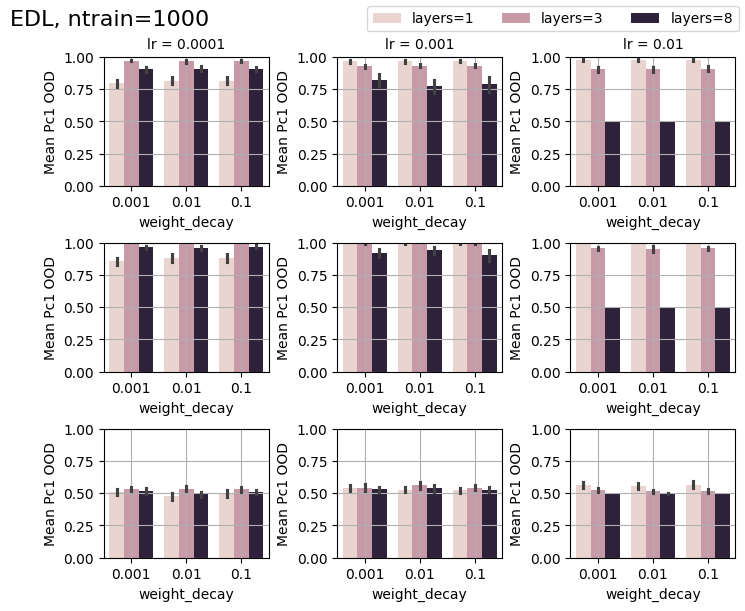

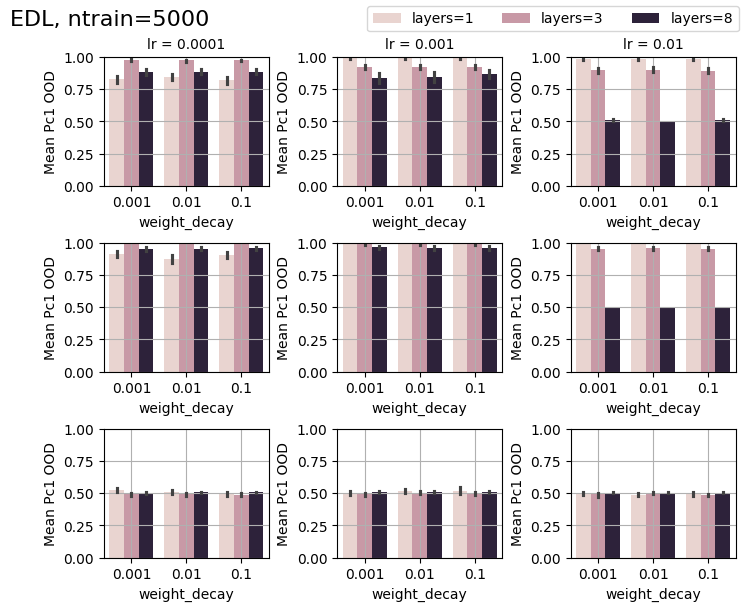

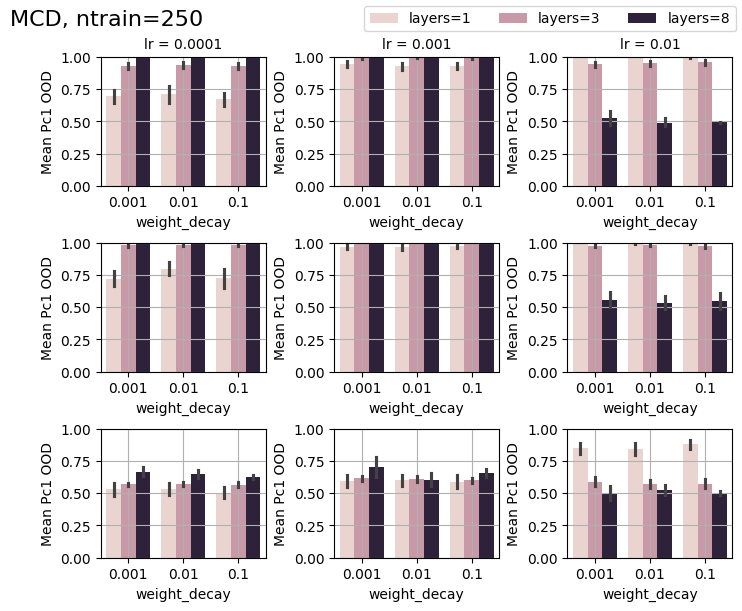

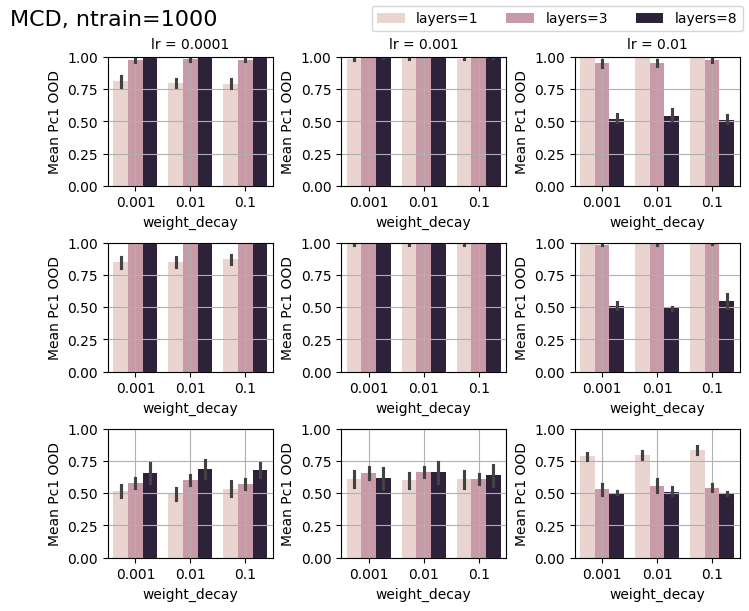

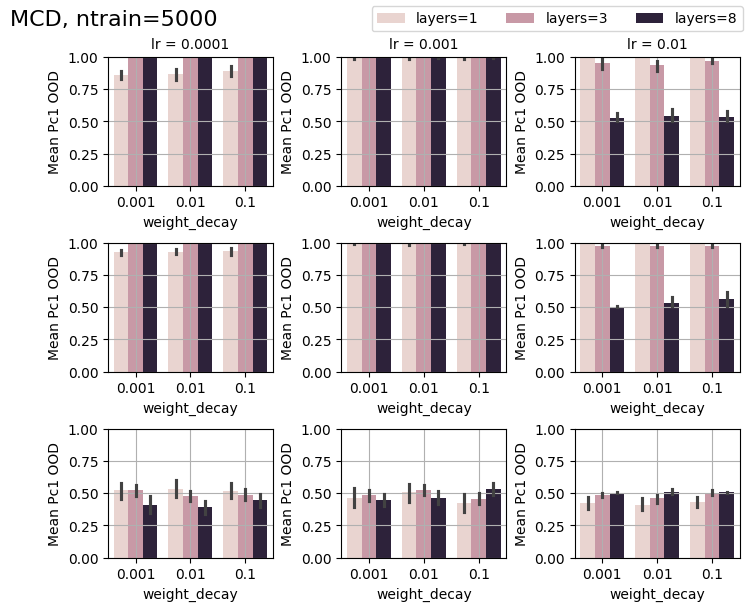

In [22]:
plot_hyperparams(dfs_A, dfs_B, dfs_C, model_names, n_data, hyperparams, "Mean Pc1 OOD", ymin=0, ymax=1)


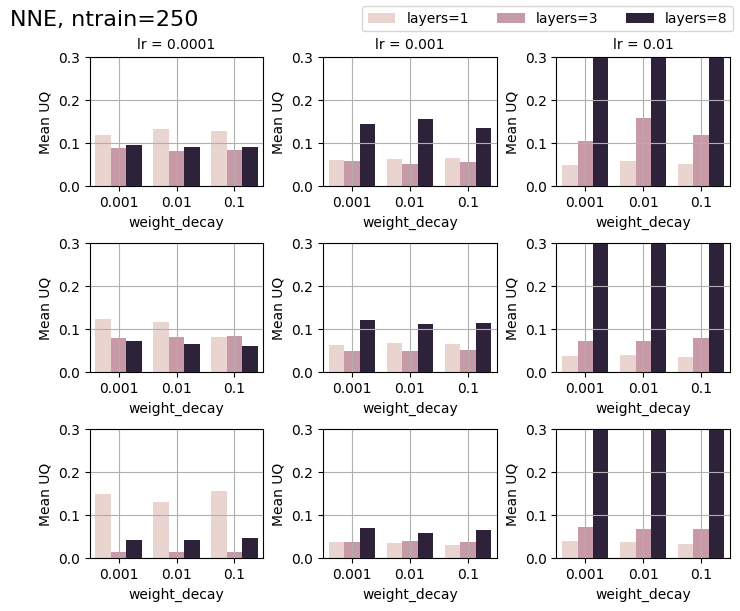

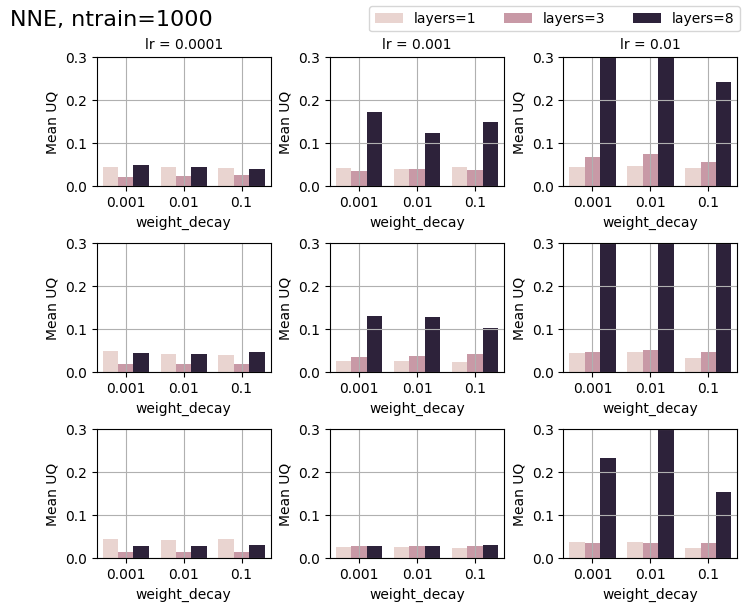

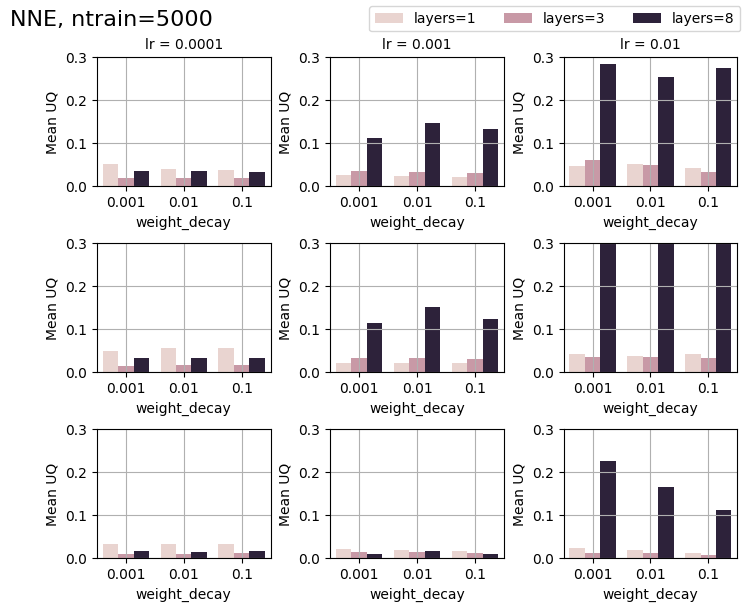

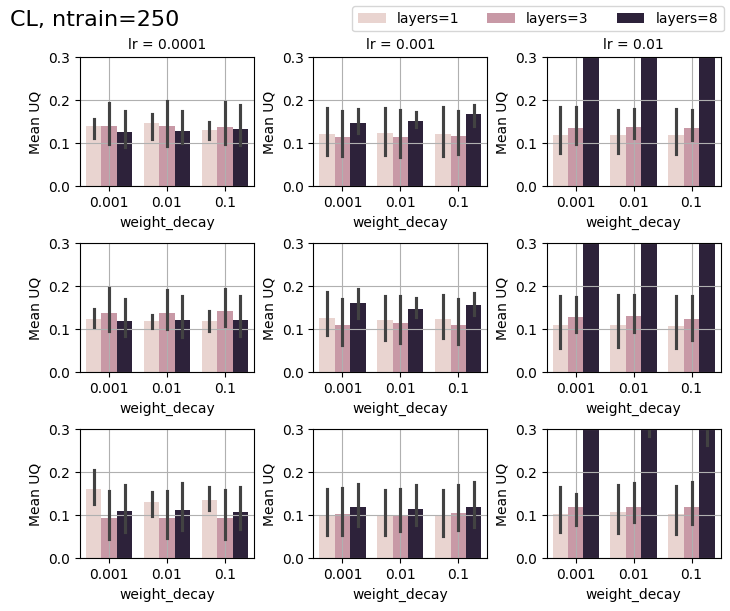

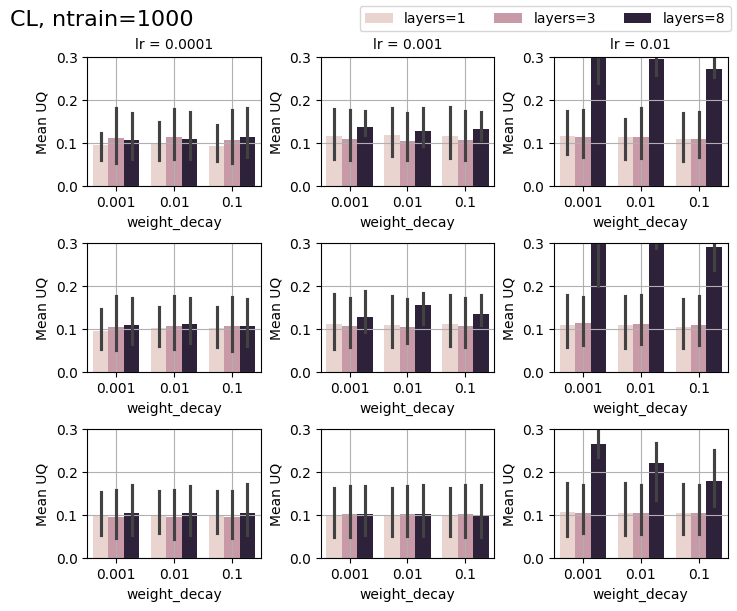

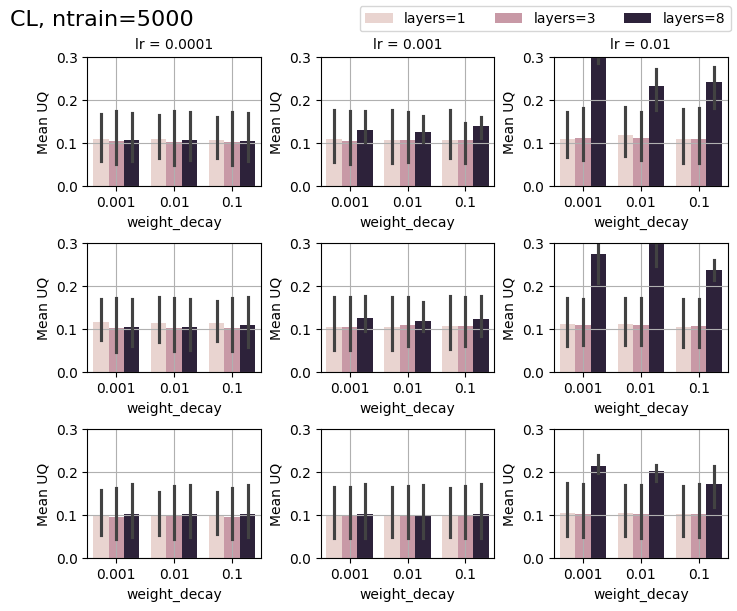

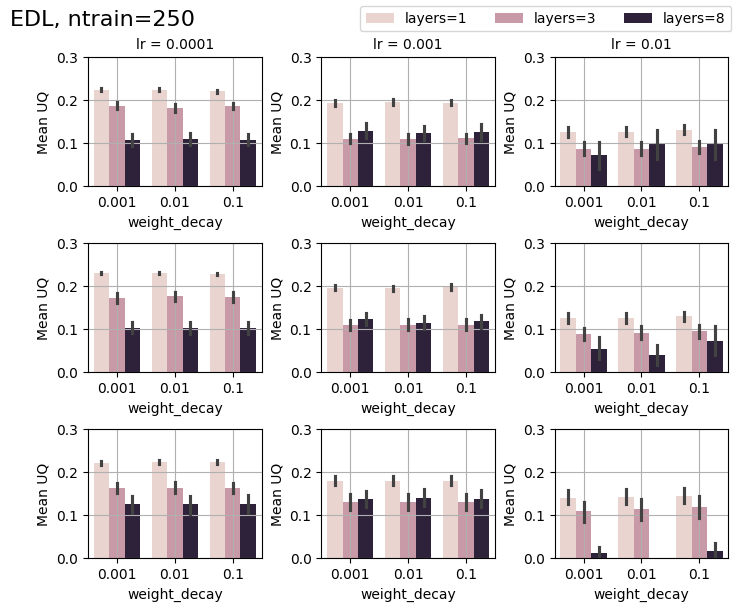

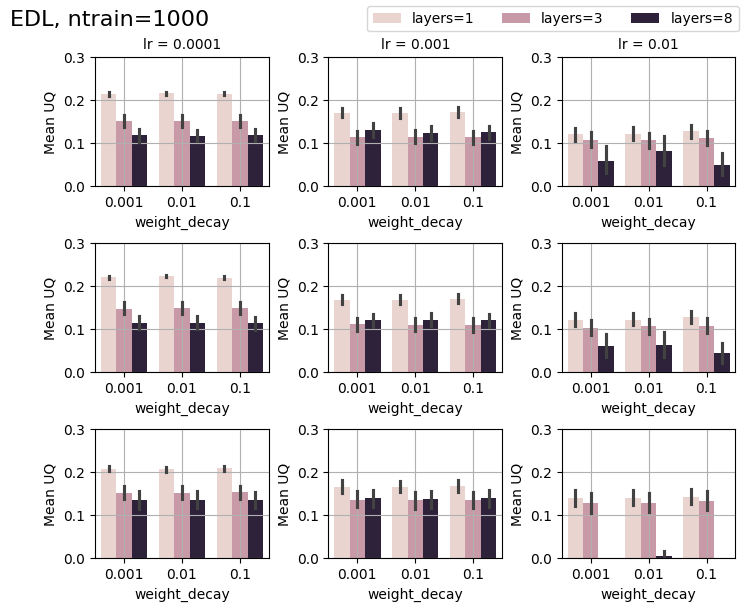

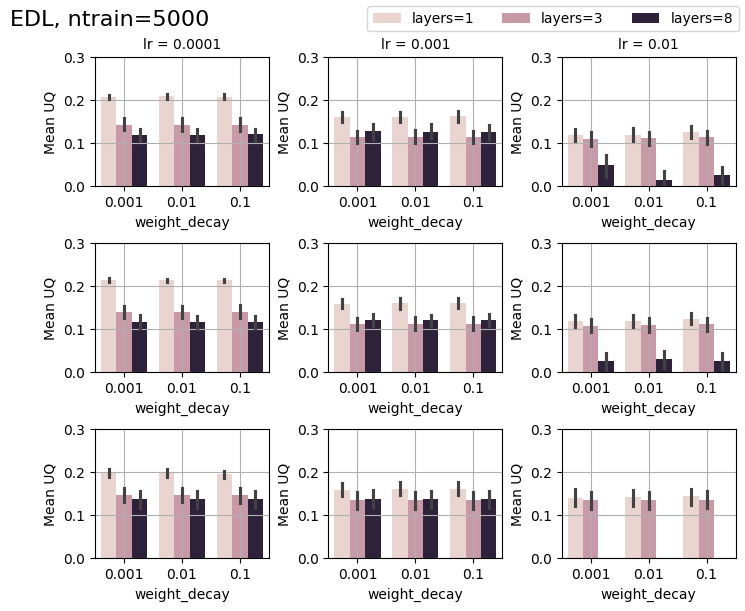

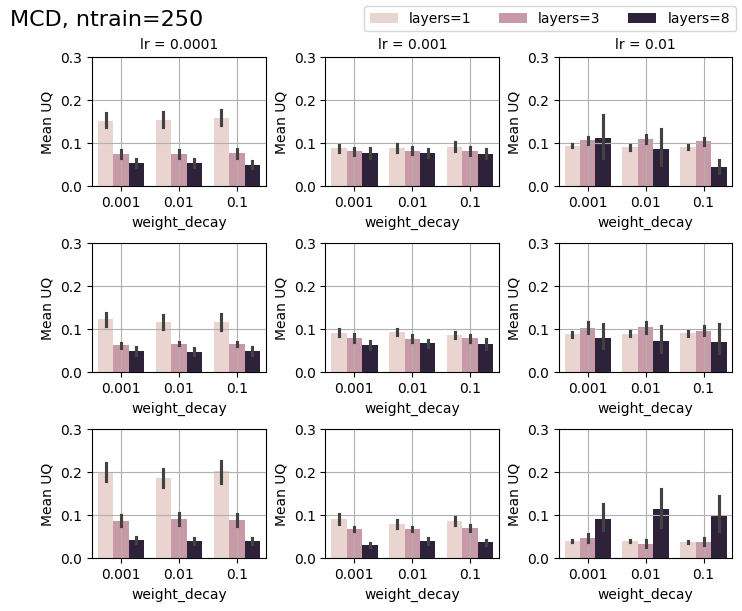

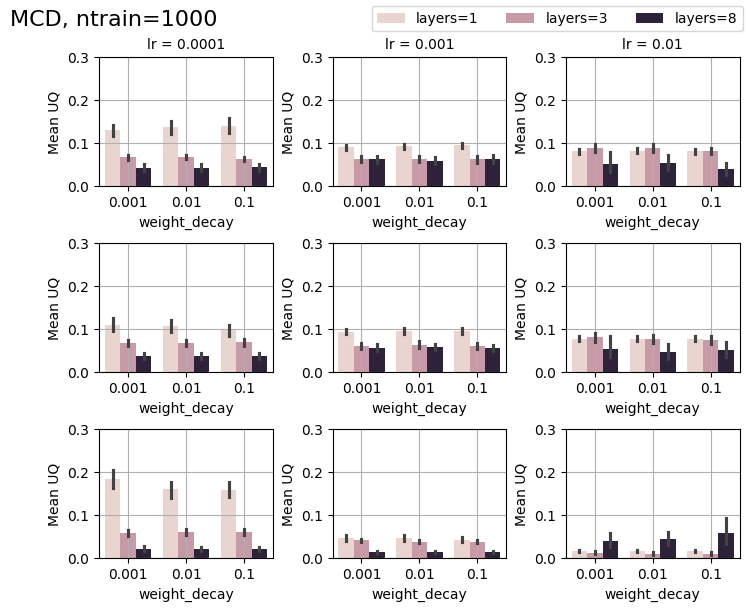

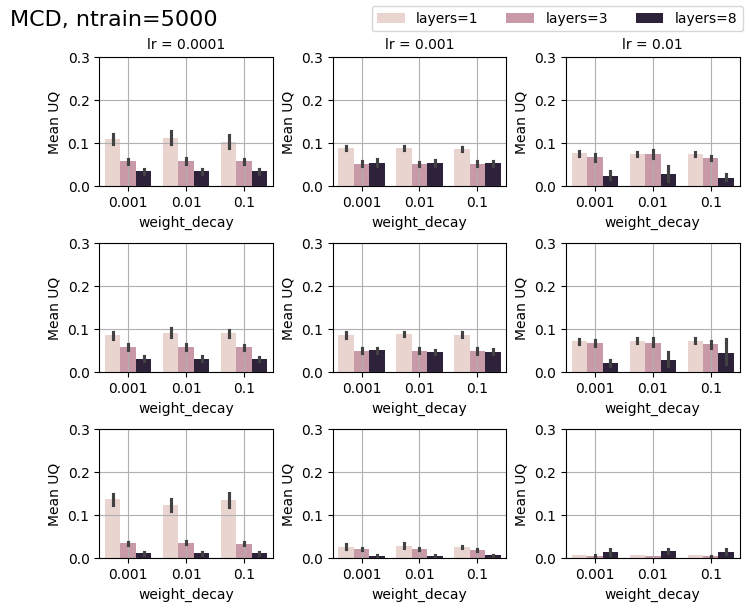

In [23]:
plot_hyperparams(dfs_A, dfs_B, dfs_C, model_names, n_data, hyperparams, "Mean UQ", ymin=0, ymax=0.3)
